<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Cleaning notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import os
import io
import gc
import math
from math import prod
from collections import Counter
import time as time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set_theme(style="darkgrid")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        columns (list): Dataframe keys in list format
        
        *args, **kwargs:
        -----------------
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                   (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            
               
def plot_values_missingno(df, first_col, last_col, *args, **kwargs):
    """
    Plotting missing values with missingno

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        first_col (int): First column to graph.
        last_col (int): Last column to graph.
        numbers_plot (int): Total numbers of graphs.
        plot_number (int): Number of the graph.
        
    Returns:
    -----------------
        None. 
        Plotting the missing values with missingno
    """
    
    # Getting the variables
    numbers_plot = kwargs.get("numbers_plot", None)
    plot_number = kwargs.get("plot_number", None)
    
    
    fig, axs = plt.subplots(2,1)
    msno.matrix(df.iloc[:, first_col:last_col], sparkline=False, fontsize=14, ax=axs[0])
    msno.bar(df.iloc[:, first_col:last_col], ax=axs[1], fontsize=14)            

    for ax in axs:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [s[:8] + "..." + s[-8:] if len(s) > 16 else s for s in labels]
        ax.axes.set_xticklabels(short_labels)

    fig.set_size_inches(18,14)
    [ax.grid() for ax in axs.flatten()];
    [sns.despine(ax=ax, right=False, left=False, top=False, bottom=False) for ax in axs.flatten()];

    plt.subplots_adjust(hspace=0.3)
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    
    if plot_number == None:
        fig.suptitle("Missing data overview", fontweight="bold", fontsize=20)
    else:
        fig.suptitle("Missing data overview\n(part " + str(plot_number) + "/" + str(numbers_plot) + ")", fontweight="bold", fontsize=20)       

    plt.show()
                        
            
def plot_missing_values(df, numbers_col):
    """
    Method used for plotting missing values

    Parameters
    -----------------
        df (pandas.DataFrame): Dataset to analyze.
        numbers_col (int): Number of columns to show in each image.
        
    Returns:
    -----------------
        None. 
    """
    
    first_col = 0
    
    if df.shape[1] // numbers_col != 0:
        
        for i in range (1, df.shape[1] // numbers_col + 1):
            
            if i == df.shape[1] // numbers_col:
                last_col = None
            else:
                last_col = i * numbers_col

            plot_values_missingno(df, first_col, last_col, numbers_plot=(df.shape[1] // numbers_col), plot_number=i)

            if i == data.shape[1] // 30:
                # deleting dataframe to free memory
                del [df]
                gc.collect()
                df = pd.DataFrame()

                break            
            else:
                first_col = last_col + 1
    else:
        
        plot_values_missingno(df, first_col, None)
            
        del [df]
        gc.collect()
        df = pd.DataFrame()
        

def encode(df):
    """
    Function to encode non-null data and replace it in the original data.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        df (pandas.DataFrame): DataFrame comparison.
        
    """
    
    # Instante package to use
    encoder = OrdinalEncoder()

    # Retains only non-null values
    no_nulls = np.array(df.dropna())
    
    # Reshapes the df for encoding
    impute_reshape = no_nulls.reshape(-1,1)
    
    # Encode df
    impute_ordinal = encoder.fit_transform(impute_reshape)
    
    # Assign back encoded values to non-null values
    df.loc[df.notnull()] = np.squeeze(impute_ordinal)
    
    return df
        

class GroupImputer(BaseEstimator, TransformerMixin):
    """ 
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters:
    -----------------  
        group_cols (list) : List of columns used for calculating the aggregated value 
        strategy (str) : The strategy to be used for remplacement, can be one of ["mean", "median", "mode"]
        
    Returns:
    -----------------
        X (array-like) : The array with imputed values in the target column
   """    
    
    def __init__(self, group_cols, target, strategy="mean"):
        
        assert strategy in ["mean", "median"], "Unrecognized value for metric, should be mean/median"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        assert type(target) == list, "target should be a string"
        
        self.group_cols = group_cols
        self.target = target
        self.strategy = strategy
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, "There are missing values in group_cols"
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.strategy) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
Reading data in <b>chunks of 1 million rows</b> at a time
</div>

In [3]:
start = time.time()
chunk = pd.read_csv("datasets/en.openfoodfacts.org.products.csv", chunksize=1000000, sep="\t", encoding="UTF-8")
data = pd.concat(chunk)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,27,28,29,31,47,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Samir\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (0,8,13,29,31,47,52,64,81,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Read csv with chunks:  85.3559136390686 sec


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.2. Missing data overview</h3>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> we got the following facts:
    <ul style="list-style-type: square;">
        <li>Almost <b>80%</b> of the data present in data set are <b>missing values</b></li>
        <li>There are <b>5 empty columns</b> that we can delete</li>
        <li>There is a lot of <b>memory usage</b> with this dataset</li>
    </ul>
</div>

In [4]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760097 rows and 186 columns
- Total of NaN values:            260478039
- Percentage of NaN:              79.56 %
- Total of full duplicates rows:  1
- Total of empty rows:            0
- Total of empty columns:         5
  + The empty column are:          ['cities', 'allergens_en', 'no_nutriments', 'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760097,0,0.00
6,last_modified_datetime,object,1760097,0,0.00
63,states_en,object,1760097,0,0.00
62,states_tags,object,1760097,0,0.00
61,states,object,1760097,0,0.00
1,url,object,1760097,0,0.00
5,last_modified_t,int64,1760097,0,0.00
4,created_datetime,object,1760097,0,0.00
3,created_t,int64,1760097,0,0.00
2,creator,object,1760093,4,0.00


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

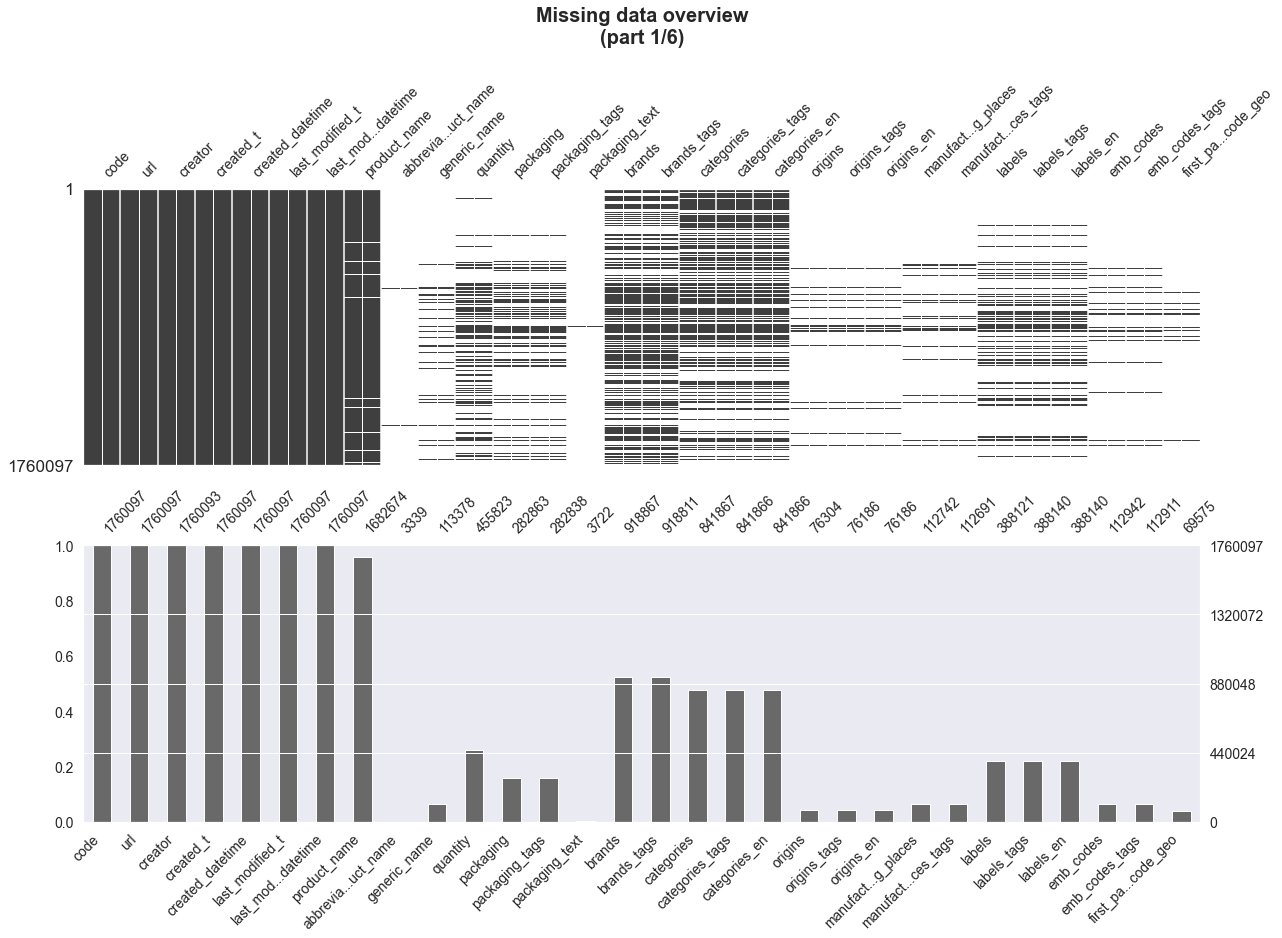

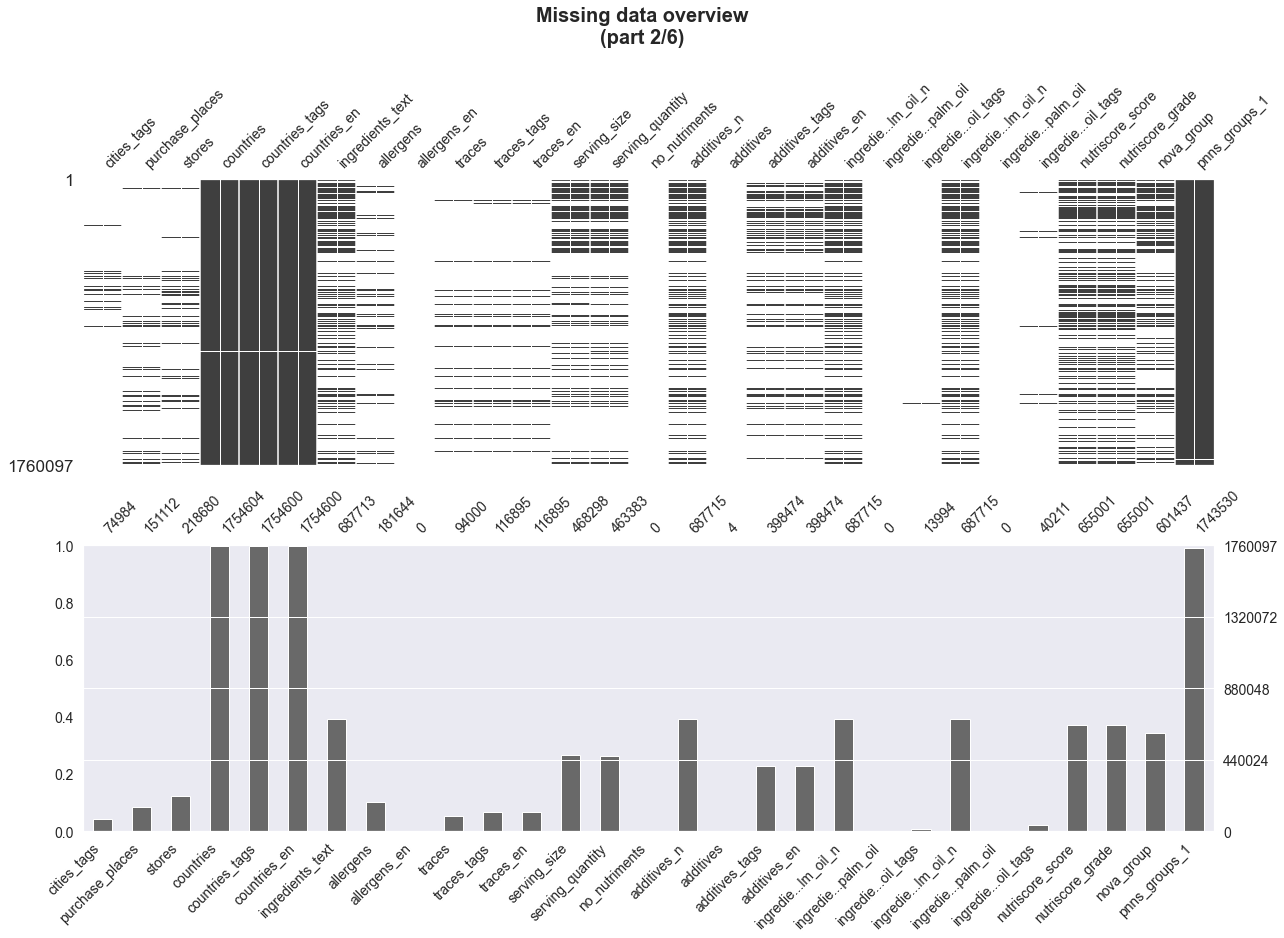

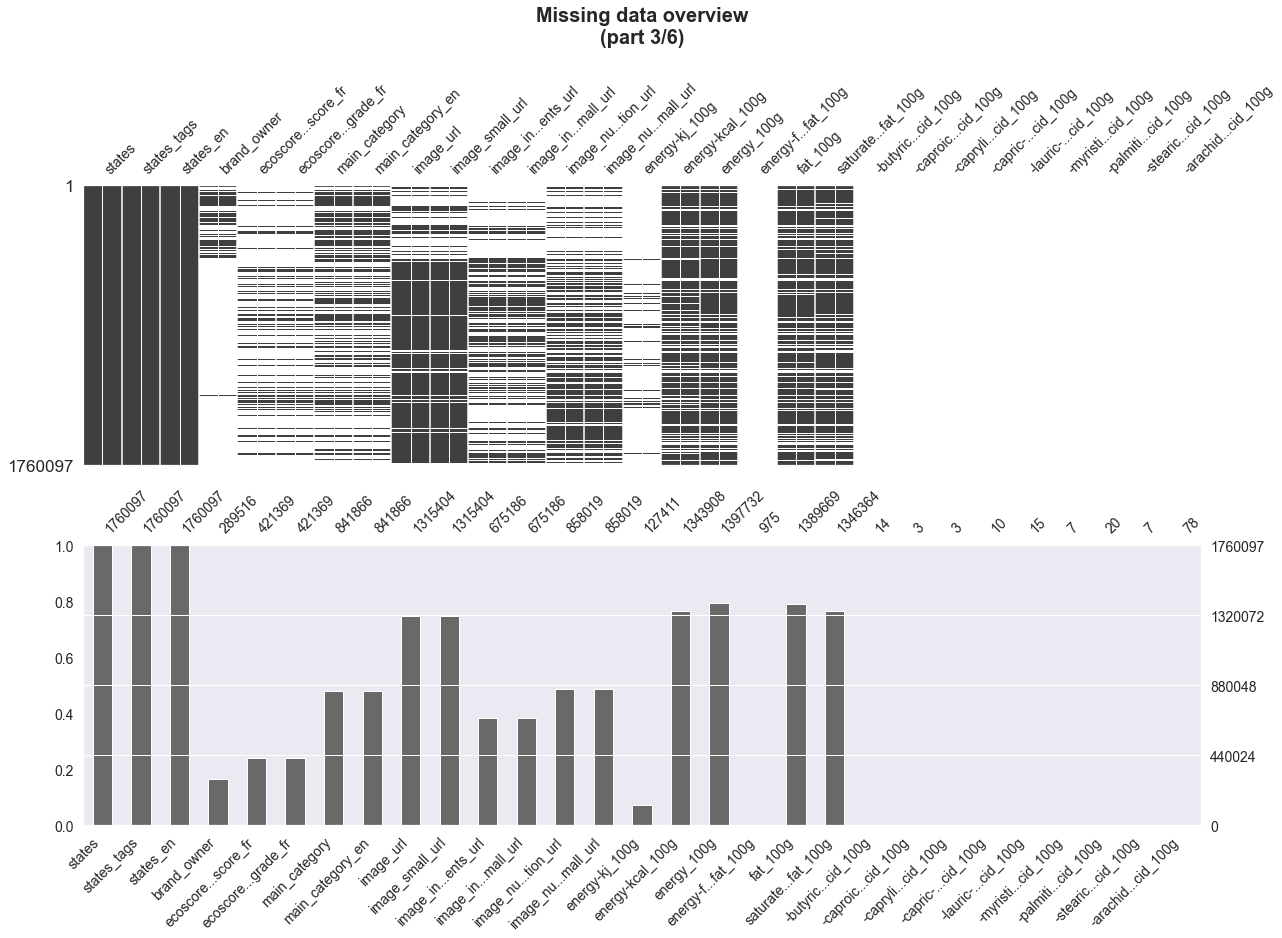

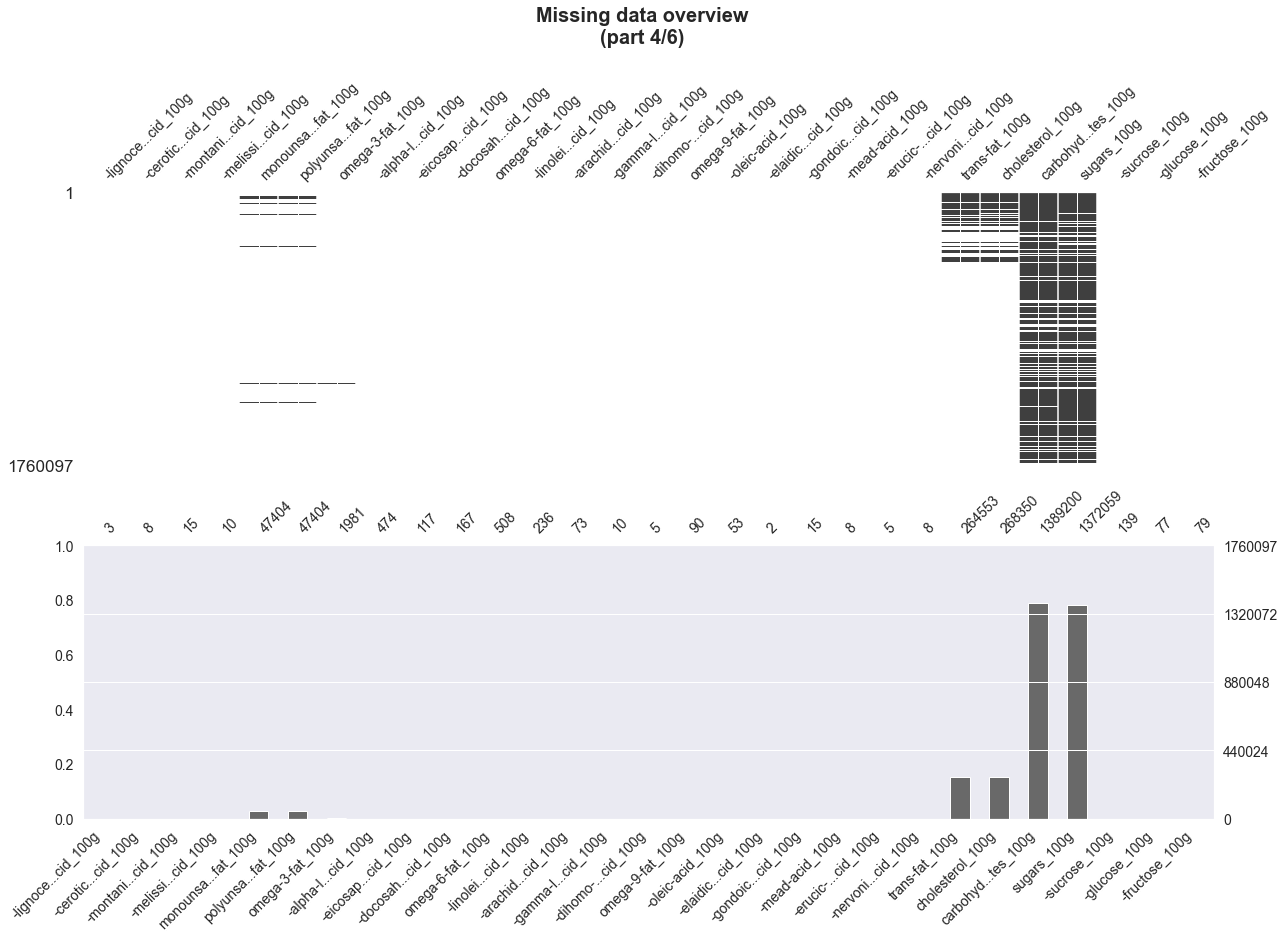

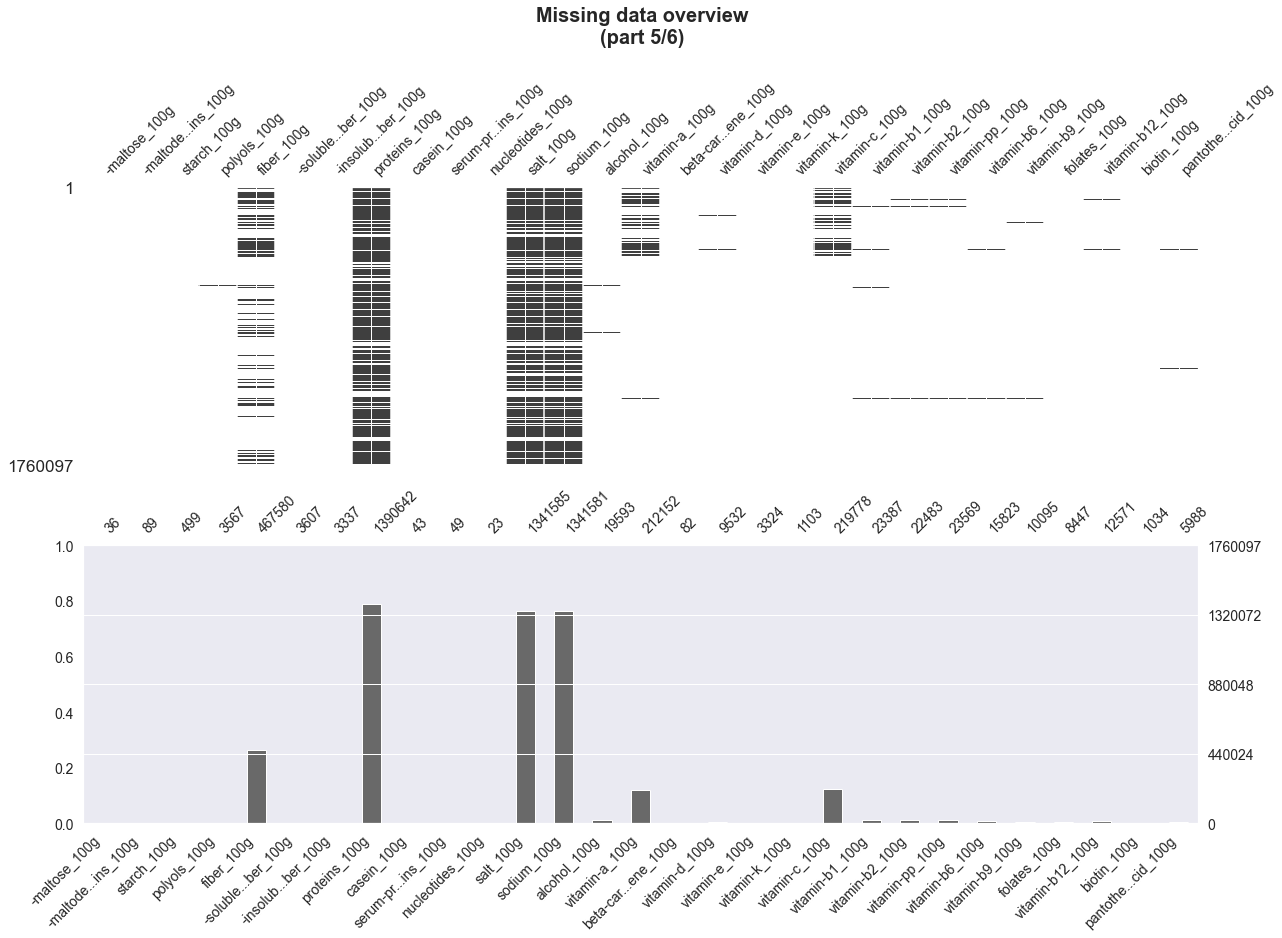

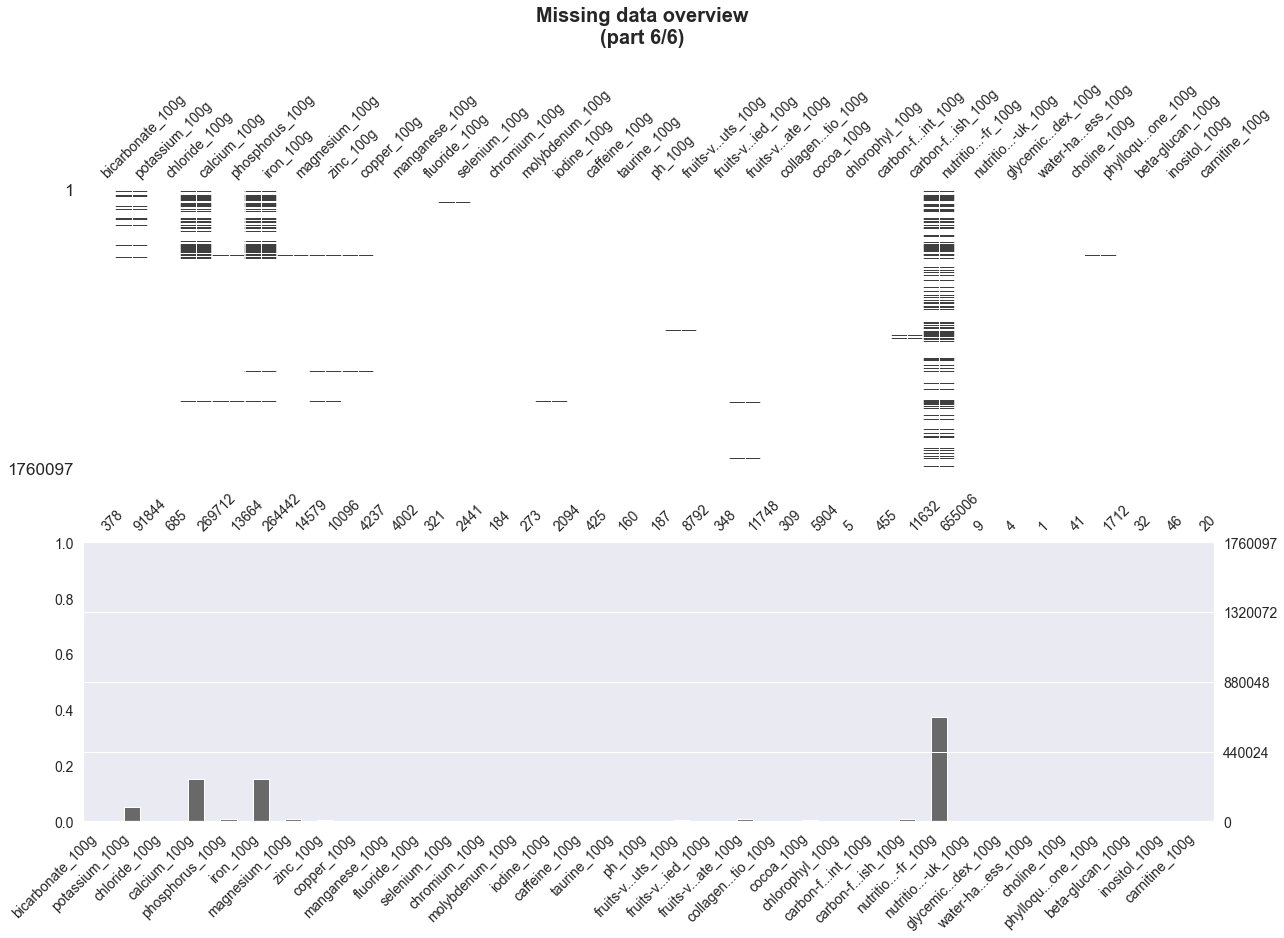

In [5]:
plot_missing_values(data, 30)

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial cleaning</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Deleting NaN columns and rows, and duplicated rows</h3>
</div>

In [6]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [7]:
data = data.drop_duplicates()

In [8]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 181 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 2.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
58,states_en,object,1760096,0,0.00
3,created_t,int64,1760096,0,0.00
4,created_datetime,object,1760096,0,0.00
5,last_modified_t,int64,1760096,0,0.00
6,last_modified_datetime,object,1760096,0,0.00
57,states_tags,object,1760096,0,0.00
1,url,object,1760096,0,0.00
56,states,object,1760096,0,0.00
2,creator,object,1760092,4,0.00


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Fixing the columns types</h3>
</div>

<div class="alert alert-block alert-warning">
There are some columns with column type wrong. We can see this information based on:
<ul style="list-style-type: square;">
    <li>Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b></li>
    <li>At the momento to <b>import the *.csv</b></li>
    <li>As a result of the function <b>df_initial_analysis</b></li>
</ul>

Due to that, we are going to proceed to fix them. 
</div>
<div class="alert alert-block alert-info">
<b>Fixing column types float64</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li>fields that end with <b>_100g</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>100 g</b> or <b>100 ml</b> of product</li>
    <li>fields that end with <b>_serving</b> correspond to <b>the amount of a nutriment</b> (in g, or kJ for energy) for <b>1</b> serving of the product</li>
</ul>

Finally, we are going to make the <b>downcast</b> from <b>float64</b> to <b>float32</b> 
</div>

In [9]:
for col in data.columns:
    if (col.endswith("_100g") or col.endswith("_serving")) and data[col].dtypes != "float64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("float64")

Column to update the column type: -butyric-acid_100g object
Column to update the column type: -capric-acid_100g object


In [10]:
for col in data.columns:
    if data[col].dtypes == "float64":
        data[col] = data[col].astype("float32")

<div class="alert alert-block alert-info">
<b>Fixing column types datetime</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following:
<ul style="list-style-type: square;">
    <li>fields that end with <b>_t</b> are dates in <b>the UNIX timestamp format</b> (number of seconds since Jan 1st 1970)</b></li>
    <li>fields that end with <b>_datetime</b> are dates in <b>the iso8601 format: yyyy-mm-ddThh:mn:ssZ</b></li>
</ul>

In this case, both group of columns have the same amount of data. Due to that, we will only keep the columns ended by <b>_datetime</b>
</div>

In [11]:
for col in data.columns:
    if col.endswith("_datetime") and data[col].dtypes != "datetime64":
        print("Column to update the column type:", col, data[col].dtypes)
        data[col] = data[col].astype("datetime64")

Column to update the column type: created_datetime object
Column to update the column type: last_modified_datetime object


In [12]:
for col in data.columns:
    if col.endswith("_t"):
        print("Column to delete:", col, data[col].dtypes)
        data = data.drop(col, axis=1)  

Column to delete: created_t int64
Column to delete: last_modified_t int64


<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [13]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: datetime64[ns](2), float32(118), object(59)
memory usage: 8.1 GB


<div class="alert alert-block alert-info">
If the number of unique values in a specific column is less than the half numbers of rows in the same column,<br>
we are going to change the type from <b>object</b> to <b>category</b> to improve the usage of memory
</div>

In [14]:
for col in data.columns:
    if data[col].dtypes == "object":
        if len(data[col].unique()) / len(data[col]) < 0.5:
            data[col] = data[col].astype("category")
        else:
            data[col] = data[col].astype("object")

<div class="alert alert-block alert-info">
Checking the usage of memory
</div>

In [15]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760096 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 2.9 GB


In [16]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  1760096 rows and 179 columns
- Total of NaN values:            251677390
- Percentage of NaN:              79.88 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 1.4+ GB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,1760096,0,0.00
54,states,category,1760096,0,0.00
56,states_en,category,1760096,0,0.00
55,states_tags,category,1760096,0,0.00
1,url,object,1760096,0,0.00
4,last_modified_datetime,datetime64[ns],1760096,0,0.00
3,created_datetime,datetime64[ns],1760096,0,0.00
2,creator,category,1760092,4,0.00
53,pnns_groups_2,category,1759729,367,0.02
31,countries,category,1754603,5493,0.31


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Filtering information</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. Filtering information by country France</h3>
</div>

<div class="alert alert-block alert-info">
<b>Countries where the product is sold</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> There are three fields about countries where the product is sold</li>
        <ul style="list-style-type: disc;">
            <li>countries</li>
            <li>countries_en</li>
            <li>countries_tags</li>
        </ul>
</ul>

After analyzing the columns, we have decided to used the columns called <b>countries</b>.<br>
We are going to filter considering only France and its overseas department
</div>

In [17]:
FILTERING_BY_FRANCE = [
    "France", "fr", "Francia", "French", "Frankreich", "Nouvelle-Calédonie", "Martinique", "Guadeloupe", "Polynésie Française", "Mayotte"
]

<div class="alert alert-block alert-success">
At this point, we have reduced the amount of data in the dataset filtering by country France
</div>

In [18]:
data = pd.DataFrame(data[data["countries"].str.contains("|".join(FILTERING_BY_FRANCE), case = False, na=False).any(level=0)])

In [19]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798009 entries, 0 to 1760096
Columns: 179 entries, code to carnitine_100g
dtypes: category(54), datetime64[ns](2), float32(118), object(5)
memory usage: 1.8 GB


In [20]:
df_analysis(data, "data", "code")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 179 columns
- Total of NaN values:            114437088
- Percentage of NaN:              80.11 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         4
  + The empty column are:          ['-lignoceric-acid_100g', '-dihomo-gamma-linolenic-acid_100g', '-elaidic-acid_100g', 'water-hardness_100g']
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns   ( memory usage: 710.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,798009,0,0.00
54,states,category,798009,0,0.00
3,created_datetime,datetime64[ns],798009,0,0.00
4,last_modified_datetime,datetime64[ns],798009,0,0.00
55,states_tags,category,798009,0,0.00
56,states_en,category,798009,0,0.00
1,url,object,798009,0,0.00
33,countries_en,category,798009,0,0.00
32,countries_tags,category,798009,0,0.00
31,countries,category,798009,0,0.00


In [21]:
data = data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

<div class="alert alert-block alert-info">
Exectuting the <b>describe()</b> function on the dataframe
</div>

In [22]:
pd.set_option("display.max_columns", None) # show full of showing cols
data.describe()

C:\Users\Samir\anaconda3\lib\site-packages\numpy\lib\function_base.py:3964: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t>=0.5)


,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,79357.000000,243846.000000,243846.000000,243846.000000,278981.000000,204621.000000,255512.000000,7.190500e+04,5.955160e+05,6.230900e+05,131.000000,617113.000000,620073.000000,3.000000e+00,2.000000,1.0,2.000,7.000000,1.00,4.000000e+00,2.000000,29.000000,12.000000,1.0,2.000000,4.000000e+00,3134.000000,3157.000000,1348.000000,340.000000,63.000000,99.000000,292.000000,203.000000,31.000000,4.000000,4.900000e+01,21.000000,3.000000,1.00000,2.000000e+00,2.000000e+00,3647.000000,3677.000000,617058.00000,619338.000000,24.000000,2.900000e+01,53.000000,228.000000,13.000000,57.000000,290.000000,765.000000,139641.000000,188.000000,181.000000,618992.000000,39.000000,31.000000,15.000000,603563.000000,603562.000000,9209.000000,3396.000000,49.000000,1.611000e+03,1785.000000,178.000000,4833.000000,2188.000000,1798.000000,1786.000000,1978.000000,1462.000000,238.000000,1.597000e+03,403.000000,928.000000,77.000000,231.000000,2683.000000,424.000000,8408.000000,1618.000000,5291.000000,2472.000000,930.000000,372.000000,392.000000,1.970000e+02,281.000000,47.000000,45.000000,343.000000,111.000000,57.000000,130.000000,6300.000000,307.000000,10488.000000,296.000000,4409.000000,3.000000,319.000000,11632.000000,278984.000000,5.000000,4.000000,31.000000,29.000000,18.000000,24.000000,14.000000
mean,118.894379,1.615872,0.048883,0.114092,9.532871,3.411380,48.509956,1.103681e+03,2.832928e+02,1.178383e+03,432.374054,14.309522,5.446947,2.582482e+20,24.014999,97.0,inf,27.353390,0.12,1.532558e+00,2.100000,3.947972,1.257143,0.0,31.000000,5.264027e-01,20.867825,9.733136,3.332329,2.166044,2.646438,0.844953,17.107796,3.695531,0.532343,0.823750,4.233134e+01,30.364353,11.001293,0.00057,1.550030e-02,7.000000e+00,0.035219,0.048734,27.36570,13.761168,17.400002,1.302966e+01,29.481323,8.522764,8.162395,5.817037,32.900581,44.481972,3.022539,2.005319,4.316906,9.138214,4.165897,4.316871,0.796109,1.310894,0.524460,6.043071,0.546040,0.869422,1.870809e-01,0.187911,0.001249,0.229725,0.900481,0.05

In [23]:
pd.reset_option("display.max_columns") # reset max of showing cols

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Application idea fields</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Idenfiying Application idea fields</h3>
</div>

<div class="alert alert-block alert-info">
Based on <b>Santé publique France</b> we can get the fiedls to calculate the <b>Nutri-Score</b><br><br>
You can see the information in details in the link below<br>
<b>https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score</b><br><br>
    
<b>Application fields</b>
<ul style="list-style-type: square;">
    <li>Energetic value</li>
    <li>Fat</li>
    <li>Saturated fat</li>
    <li>Sugar</li>
    <li>Protein</li>
    <li>Salt / Sodium</li>
    <li>Fibers</li>
    <li>Fruits, vegetables, legumes, nuts, rapeseed, walnut and olive oils</li>
    <li>Nutri Score</li>
    <li>Nova</li>
</ul>
</div>

In [24]:
pd.set_option("display.max_columns", None)
data.head(5)

,code,url,creator,created_datetime,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,serving_quantity,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,-soluble-fiber_100g,-insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15 10:38:00,2019-06-25 11:55:18,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",NaN,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,375.0,1569.0,NaN,7.0,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.099998,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8,NaN,NaN,NaN,1.40,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [25]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
After analyzing the columns we can identify the following fields for <b>Nutri-Score</b> <b>and App idea</b> 
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
        <td align="left"></td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
  	<tr>
		<td align="left">Fibers</td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">Nutri Score</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">nutriscore_score<br/>nutrition-score-fr_100g</td>
        <td align="left">It is necessary to analyze these fields more in details. </td>
 	</tr>
  	<tr>
		<td align="left">Nova</td>
        <td align="center">Nutri-score</td>
		<td align="center">No</td>
        <td align="left">nova_group</td>
        <td align="left"></td>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-score</td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
    <tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
        <td align="left"></td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Brand</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">It is necessary to analyze these fields more in details.</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
        <td align="left"></td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Analyzing  the Application idea fields</h3>
</div>

<div class="alert alert-block alert-info">
    Let's create a dataframe with interesting fields of the <b>application idea</b>
</div>

In [27]:
BASIC_FIELDS = [
    "code", "last_modified_datetime", "product_name", "brands", "brands_tags",
    "categories", "main_category", "main_category_en", "categories_tags", 
    "categories_en", "image_url"
]

In [28]:
NUTRI_SCORE_FIELDS = [
    "energy-kj_100g", "energy-kcal_100g", "energy_100g", "fat_100g", "saturated-fat_100g", 
    "sugars_100g", "proteins_100g", "salt_100g", "sodium_100g", "fiber_100g", 
    "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g", 
    "nutriscore_score", "nutrition-score-fr_100g"
]

In [29]:
df_app = data[BASIC_FIELDS + NUTRI_SCORE_FIELDS].copy(deep=True)

<div class="alert alert-block alert-info">
Deleting <b>data</b> dataframe to free memory
</div>

In [37]:
del data
gc.collect()
data = pd.DataFrame()

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [38]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 26 columns
- Total of NaN values:            9121069
- Percentage of NaN:              43.96 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 114.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,798009,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],798009,696994,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,775020,528750,22989,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720228,720158,77781,9.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623090,4545,174919,21.92,1178.382935,0.0,464.000,1100.000000,1674.000000,12200000.0,15538.601562
15,saturated-fat_100g,float32,620073,3684,177936,22.30,5.446947,0.0,0.200,2.000000,8.000000,21900.0,29.066158
16,sugars_100g,float32,619338,5341,178671,22.39,13.761168,-1.0,0.600,3.500000,19.985256,6880.0,21.925907
17,proteins_100g,float32,618992,4101,179017,22.43,9.138214,0.0,1.500,6.200000,12.900000,173000.0,220.102295
14,fat_100g,float32,617113,4941,180896,22.67,14.309522,0.0,1.000,8.000000,22.000000,91200.0,117.423164
18,salt_100g,float32,603563,6284,194446,24.37,1.310894,0.0,0.060,0.510000,1.300000,25000.0,32.950630


<div class="alert alert-block alert-info">
    Processing the duplicates
</div>

In [39]:
df_app.drop_duplicates(inplace=True)

In [40]:
df_app.shape

(798009, 26)

<div class="alert alert-block alert-success">
    At this point, we have the <b>Application idea</b> dataframe.<br>
    In the next section, we are going to analyze in details, the dataframe's fields. 
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Cleaning Nutri-Score and App idea dataframe</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. Analyzing products without a barcode</h3>
</div>

<div class="alert alert-block alert-info">
<b>Analyzing products without a barcode</b><br>
Based on Open Food Facts data-fileds: <b>https://world.openfoodfacts.org/data/data-fields.txt</b>, we know the following
<ul style="list-style-type: square;">
    <li> <b>code :</b> barcode of the product (can be EAN-13 or internal codes for some food stores),<br> for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix</li>
</ul>
</div>

In [41]:
df_temp = pd.DataFrame(df_app.loc[df_app["code"].str.startswith("200", na=False)])

In [42]:
df_analysis(df_temp, "temp", "code", flag="complete")


Analysis of temp dataset
--------------------------------------------------------------------
- Dataset shape:                  5961 rows and 26 columns
- Total of NaN values:            71167
- Percentage of NaN:              45.92 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 21.1+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,5961,5961,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],5961,5831,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,5795,5371,166,2.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,5404,5404,557,9.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,4108,1090,1853,31.09,1151.472778,0.0,510.00,1070.000,1640.000000,6276.000000,785.627747
14,fat_100g,float32,4083,511,1878,31.50,13.668987,0.0,1.70,8.900,21.000000,100.000000,15.770761
17,proteins_100g,float32,4070,376,1891,31.72,8.128023,0.0,2.80,6.300,11.000000,85.650002,8.048944
15,saturated-fat_100g,float32,4041,424,1920,32.21,5.574977,0.0,0.40,2.500,8.800000,100.000000,7.425464
16,sugars_100g,float32,4035,614,1926,32.31,13.764969,0.0,1.10,4.800,19.799999,100.000000,18.451021
19,sodium_100g,float32,4006,490,1955,32.80,0.513575,0.0,0.04,0.272,0.492000,56.000000,2.030981


<div class="alert alert-block alert-info">
Plotting missing values with <b>missingno</b>
</div>

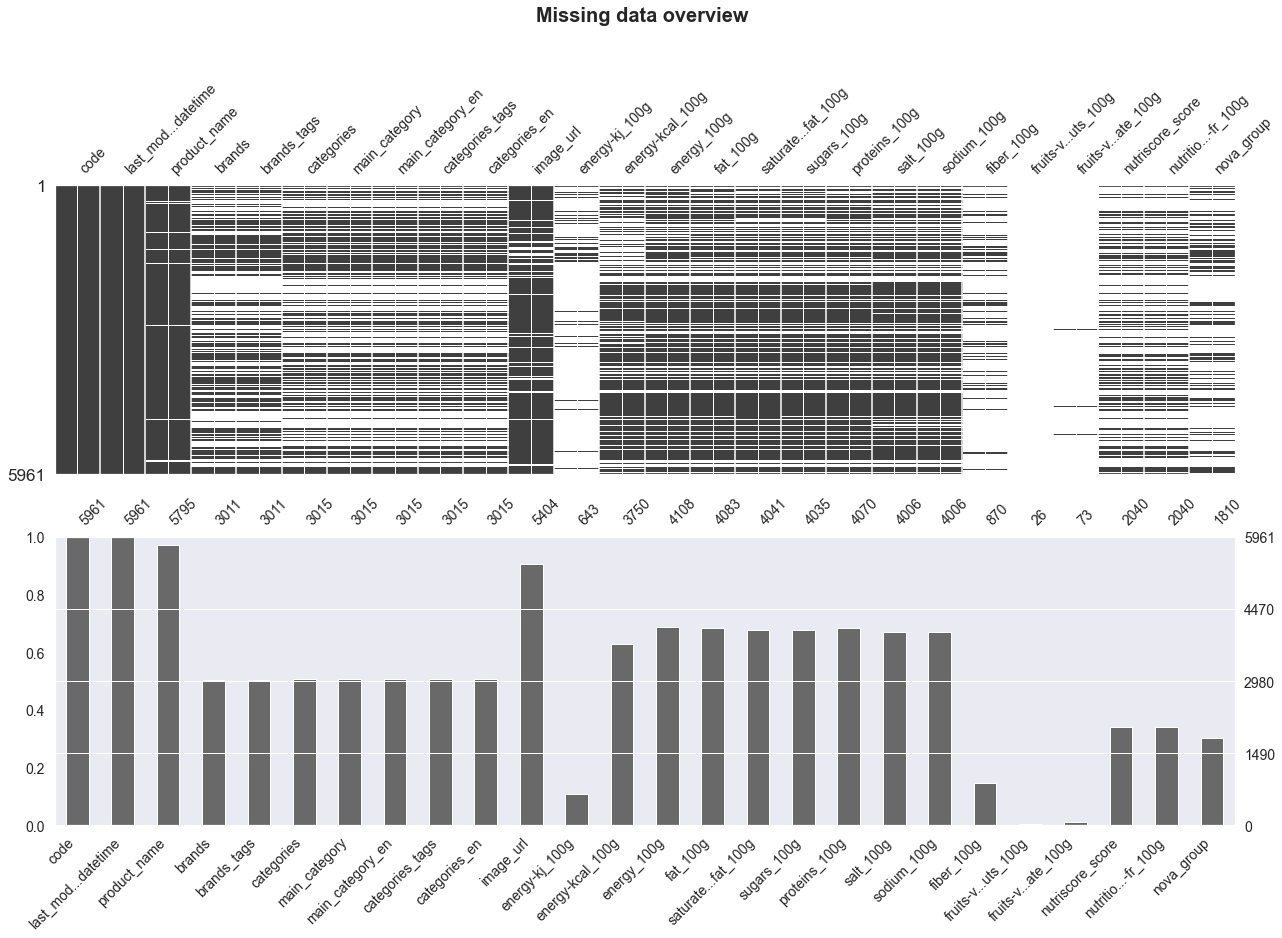

In [43]:
plot_missing_values(df_temp, 30)

<div class="alert alert-block alert-success">
<b>Analyzing products without a barcode</b><br>
After analyzing the products without barcode in Open Food Facts, we have decided to <b>keep them</b>,<br>because these records <b>can be found</b> through the name at the time of a <b>search</b> for a product by a user.    
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Processing the non-uniques codes</h3>
</div>

In [44]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  798009 rows and 26 columns
- Total of NaN values:            9121069
- Percentage of NaN:              43.96 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 114.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,798009,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],798009,696994,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,775020,528750,22989,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720228,720158,77781,9.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623090,4545,174919,21.92,1178.382935,0.0,464.000,1100.000000,1674.000000,12200000.0,15538.601562
15,saturated-fat_100g,float32,620073,3684,177936,22.30,5.446947,0.0,0.200,2.000000,8.000000,21900.0,29.066158
16,sugars_100g,float32,619338,5341,178671,22.39,13.761168,-1.0,0.600,3.500000,19.985256,6880.0,21.925907
17,proteins_100g,float32,618992,4101,179017,22.43,9.138214,0.0,1.500,6.200000,12.900000,173000.0,220.102295
14,fat_100g,float32,617113,4941,180896,22.67,14.309522,0.0,1.000,8.000000,22.000000,91200.0,117.423164
18,salt_100g,float32,603563,6284,194446,24.37,1.310894,0.0,0.060,0.510000,1.300000,25000.0,32.950630


<div class="alert alert-block alert-warning">
    Based on the function <b>df_analysis</b> result, we can see that there are some codes which are not unique so, it is necessary to work on them</br></br>
    
<b>The message</b><br>
<i>- The key(s): code is present multiple times in the dataframe.<br>
&nbsp;&nbsp;&nbsp;It CANNOT be used as a primary key."</i></br>
   
</br>To do this, we are going to make the following steps:
<ul style="list-style-type: square;">
    <li>Filter the dataset by non-unique <b>code</b></li>
    <li>Select most recent value based on year for each code considering the multiples columns</li>
    <li>Merge the dataset with the filtered information</li>
</ul>
</div>

In [45]:
df_temp = df_app[df_app.duplicated(subset=["code"], keep=False)].copy()
df_temp = df_temp.sort_values(["code", "last_modified_datetime"], ascending=True)

In [46]:
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
577581,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.400000,1.5,0.30,0.120,NaN,NaN,NaN,NaN,NaN,NaN
48759,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,10.400000,1.5,0.25,0.100,2.3,NaN,NaN,3.0,3.0,3.0
662890,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.500000,10.7,1.20,0.480,NaN,NaN,NaN,NaN,NaN,NaN
63896,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,2.500000,10.7,1.30,0.520,3.8,NaN,NaN,9.0,9.0,NaN
780012,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.599998,4.0,0.33,0.132,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_temp = pd.DataFrame(df_temp).reset_index()

In [48]:
del df_temp["index"]
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.400000,1.5,0.30,0.120,NaN,NaN,NaN,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,10.400000,1.5,0.25,0.100,2.3,NaN,NaN,3.0,3.0,3.0
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.500000,10.7,1.20,0.480,NaN,NaN,NaN,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,2.500000,10.7,1.30,0.520,3.8,NaN,NaN,9.0,9.0,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.599998,4.0,0.33,0.132,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_temp = df_temp.rename_axis(None, axis=1)

In [50]:
df_temp.head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
0,246804,2019-06-01 09:59:11,"Salade Chou, Pomme, céleri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.400000,1.5,0.30,0.120,NaN,NaN,NaN,NaN,NaN,NaN
1,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,10.400000,1.5,0.25,0.100,2.3,NaN,NaN,3.0,3.0,3.0
2,315739,2019-07-23 18:22:59,Sandwich Jambon Fromage Sans Gluten,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.500000,10.7,1.20,0.480,NaN,NaN,NaN,NaN,NaN,NaN
3,315739,2019-12-02 14:52:43,NaN,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,2.500000,10.7,1.30,0.520,3.8,NaN,NaN,9.0,9.0,NaN
4,331470,2019-07-23 10:57:35,4 Gluten Free zesty lemon muffins,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.599998,4.0,0.33,0.132,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Select most recent value based on year for each code considering the multiples columns
</div>

In [51]:
df_temp = df_temp.groupby("code", as_index=False).last()

In [52]:
df_temp.head(6)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
0,246804,2020-12-10 19:57:25,"Salade chou,pomme,céleri",M&S,m-s,"Plats préparés, Salades, Salades composées, Sa...",en:vegetable-salads,Vegetable salads,"en:meals,en:salads,en:prepared-salads,en:veget...","Meals,Salads,Prepared salads,Vegetable salads",...,10.400000,1.5,0.25,0.100,2.3,NaN,NaN,3.0,3.0,3.0
1,315739,2019-12-02 14:52:43,Sandwich Jambon Fromage Sans Gluten,Marks And Spencer,marks-and-spencer,"Sandwichs, Sandwichs garnis de charcuteries, S...",en:ham-and-cheese-sandwiches,Ham and cheese sandwiches,"en:sandwiches,en:sandwiches-filled-with-cold-c...","Sandwiches,Sandwiches filled with cold cuts,Ch...",...,2.500000,10.7,1.30,0.520,3.8,NaN,NaN,9.0,9.0,NaN
2,331470,2021-04-01 13:41:55,Muffins au citron,Marks & Spencer,marks-spencer,"Biscuits et gâteaux, Gâteaux, Muffins, Muffins...",fr:muffins-au-citron,fr:muffins-au-citron,"en:biscuits-and-cakes,en:cakes,en:muffins,en:f...","Biscuits and cakes,Cakes,Muffins,Fruit Muffins...",...,33.599998,4.0,0.33,0.132,NaN,NaN,NaN,NaN,NaN,NaN
3,333214,2019-07-31 12:37:28,Belgium milk chocolate coated toffee popcorn,Casino,casino,"Produits de la mer, Produits à tartiner, Produ...",en:taramasalata,Taramasalata,"en:seafood,en:spreads,en:salted-spreads,en:tar...","Seafood,Spreads,Salted spreads,Taramasalata",...,48.299999,6.1,1.05,0.420,0.0,NaN,NaN,16.0,16.0,4.0
4,352536,2019-09-15 14:15:32,Fab Flamingo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.299999,0.3,0.55,0.220,NaN,NaN,NaN,NaN,NaN,NaN
5,360616,2020-01-13 16:40:52,Green Thai curry & jasmin rice,Marks And Spencer,marks-and-spencer,NaN,NaN,NaN,NaN,NaN,...,2.600000,3.6,0.40,0.160,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info">
    Deleting the non-unique values from <b>Nutri-Score</b> dataset
</div>

In [53]:
df_temp.shape

(60, 26)

In [54]:
df_app.shape

(798009, 26)

In [55]:
df_app = df_app[~df_app["code"].isin(df_temp["code"])]

In [56]:
df_app.shape

(797889, 26)

<div class="alert alert-block alert-info">
    Concatenating the datasets to have <b>only unique</b> values by <b>code</b>
</div>

In [57]:
df_app = pd.concat([df_app, df_temp])

In [58]:
df_app.shape

(797949, 26)

In [59]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 26 columns
- Total of NaN values:            9120105
- Percentage of NaN:              43.96 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 114.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.000,1100.000000,1674.000000,12200000.0,15539.136719
15,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
16,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
17,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
14,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
18,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717


<div class="alert alert-block alert-success">
    At this point, we have combined the product non-uniques with <b>the plus recent data</b> deleting 60 records
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.3. Analyzing the Energy columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
		<td align="center">Yes</td>
        <td align="left">
            energy-kj_100g<br>
            energy-kcal_100g<br>
            energy_100g</td>
        <td align="left">
            The fields energy-kj_100g and energy_100g seem to be the same value.<br>
            Consider the measure units to work with the values.
        </td>
 	</tr>
</table>

In [60]:
df_analysis(df_app[["code", "energy_100g", "energy-kcal_100g", "energy-kj_100g"]], "df_nutri_score", "code", flag="complete")


Analysis of df_nutri_score dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 4 columns
- Total of NaN values:            1103419
- Percentage of NaN:              34.57 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 37.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768
3,energy-kj_100g,float32,71900,3608,726049,90.99,1103.704102,0.0,435.0,977.0,1610.0,1094259.0,4161.389160


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [61]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [62]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)
df_app[df_app["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Ferrero,Nutella","ferrero,nutella","Produits à tartiner,Petit-déjeuners,Aides culinaires,Produits à tartiner sucrés,Aides à la pâtisserie,Pâtes à tartiner,Pâtes à tartiner aux noisettes,Pâtes à tartiner au chocolat,Pâtes à tartiner aux noisettes et au cacao,Aide culinaire sucrée",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en:sweet-spreads,en:pastry-helpers,fr:pates-a-tartiner,en:hazelnut-spreads,en:chocolate-spreads,en:cocoa-and-hazelnuts-spreads,en:sugary-cooking-helpers","Spreads,Breakfasts,Cooking helpers,Sweet spreads,Pastry helpers,fr:Pâtes à tartiner,Hazelnut spreads,Chocolate spreads,Cocoa and hazelnuts spreads,Sugary cooking helpers",https://static.openfoodfacts.org/images/products/301/762/042/2003/front_fr.260.400.jpg,2252.0,539.0,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN,26.0,26.0,4.0
637275,3033710065967,2021-03-02 09:38:08,Nesquik,Nestlé,nestle,"Boissons, Petit-déjeuners, Cacaos et chocolats en poudre, Boissons instantanées, Chocolats en poudre",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-products,en:cocoa-and-chocolate-powders,en:instant-beverages,en:chocolate-powders","Beverages,Breakfasts,Cocoa and its products,Cocoa and chocolate powders,Instant beverages,Chocolate powders",https://static.openfoodfacts.org/images/products/303/371/006/5967/front_fr.266.400.jpg,1591.0,376.0,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN,1.0,1.0,4.0
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,bjorg,bjorg,"Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits, Biscuits au chocolat, Biscuits-fourres-chocolat",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits,en:chocolate-biscuits,fr:biscuits-fourres-chocolat","Snacks,Sweet snacks,Biscuits and cakes,Biscuits,Chocolate biscuits,fr:biscuits-fourres-chocolat",https://static.openfoodfacts.org/images/products/322/982/010/0234/front_fr.115.400.jpg,2004.0,478.0,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN,13.0,13.0,4.0


In [63]:
pd.reset_option("max_colwidth")
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
The <b>energy_100g</b> and <b>energy-kj_100g</b> fields are the same but it is necessary to compare in details these columns</br>
Let's compare the fields considering the <b>energy-kj_100g</b> as main field because it has <b>fewer data</b> than The <b>energy_100g</b> field
<ul style="list-style-type: square;">
    <li><b>energy_100g</b> has 623047 values</li>
    <li><b>energy-kj_100g</b> has 71900 values</li>
</ul>
</div>

In [64]:
df_temp = df_app[df_app["energy-kj_100g"].notnull()]

In [65]:
df_temp = pd.DataFrame(df_temp[["code", "energy_100g", "energy-kj_100g"]])

<div class="alert alert-block alert-info">
Now, let's compare <b>energy_100g</b> with <b>energy-kcal_100g</b> 
</div>

In [66]:
df_temp["comparison_column"] = np.where(df_temp["energy_100g"] == df_temp["energy-kj_100g"], True, False)

In [67]:
print("Amount of rows with differentes data between \"energy_100g\" and \"energy-kj_100g\" is:",
        df_temp[df_temp["comparison_column"] == False].shape[0]
)

Amount of rows with differentes data between "energy_100g" and "energy-kj_100g" is: 4


<div class="alert alert-block alert-success">
At this point, we got that there are only 4 rows with different data between <b>energy_100g</b> and <b>energy-kj_100g</b> fields so,</br> we can proceed to delete the <b>energy-kj_100g</b> field because the error could be minimum
</div>

In [68]:
del df_app["energy-kj_100g"]

In [69]:
df_analysis(df_app[["code", "energy_100g", "energy-kcal_100g"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            377370
- Percentage of NaN:              15.76 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,energy_100g,float32,623047,4545,174902,21.92,1178.401978,0.0,464.0,1100.0,1674.0,12200000.0,15539.136719
2,energy-kcal_100g,float32,595481,5536,202468,25.37,283.296692,0.0,111.0,265.0,402.0,2910000.0,3785.686768


<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [70]:
VALUES_TEMP = [
    "3017620422003", "3033710065967", "3229820100234"
]

In [71]:
pd.set_option("display.max_columns", None)
df_app[df_app["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,image_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
629040,3017620422003,2021-04-24 16:51:44,Nutella,"Ferrero,Nutella","ferrero,nutella","Produits à tartiner,Petit-déjeuners,Aides culi...",en:sugary-cooking-helpers,Sugary cooking helpers,"en:spreads,en:breakfasts,en:cooking-helpers,en...","Spreads,Breakfasts,Cooking helpers,Sweet sprea...",https://static.openfoodfacts.org/images/produc...,539.0,2252.0,30.9,10.6,56.299999,6.3,0.107,0.0428,NaN,NaN,NaN,26.0,26.0,4.0
637275,3033710065967,2021-03-02 09:38:08,Nesquik,Nestlé,nestle,"Boissons, Petit-déjeuners, Cacaos et chocolats...",en:chocolate-powders,Chocolate powders,"en:beverages,en:breakfasts,en:cocoa-and-its-pr...","Beverages,Breakfasts,Cocoa and its products,Co...",https://static.openfoodfacts.org/images/produc...,376.0,1591.0,3.0,1.5,75.000000,5.0,0.400,0.1600,6.5,NaN,NaN,1.0,1.0,4.0
688799,3229820100234,2021-03-27 15:25:14,Fourrés Chocolat noir,bjorg,bjorg,"Snacks, Snacks sucrés, Biscuits et gâteaux, Bi...",fr:biscuits-fourres-chocolat,fr:biscuits-fourres-chocolat,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuit...",https://static.openfoodfacts.org/images/produc...,478.0,2004.0,20.0,7.0,27.000000,7.1,0.500,0.2000,4.8,NaN,NaN,13.0,13.0,4.0


In [72]:
pd.reset_option("display.max_columns")

<div class="alert alert-block alert-info">
As you know, at this point we have deleted <b>energy-kj_100g</b> field beacuse it is the same as <b>energy_100g</b><br><br>

On the other hand, we know the following:
<ul style="list-style-type: square;">
    <li>1 kcal = 4,1868 kJ</li>
    <li>1 kJ = 0,2388 kcal</li>
</ul>

So, we can try to complete the <b>energy_100g</b> field with values of <b>energy-kcal_100g</b> field after the respective unit of measure conversion
    
First of all, let's check whether there is some <b>energy_100g</b> values that we can complete with <b>energy-kj_100g</b> values
</div>

In [73]:
print("Amount of \"energy_100g\" to complete with \"energy-kcal_100g\" is:",
        df_app[(df_app["energy_100g"].isna()) & (df_app["energy-kcal_100g"].notnull())].shape[0]
)

Amount of "energy_100g" to complete with "energy-kcal_100g" is: 0


<div class="alert alert-block alert-success">
    There is not some <b>energy_100g</b> values that we can complete with <b>energy-kcal_100g</b> values so,</br> we can proceed to delete the <b>energy-kcal_100g</b> field
</div>

In [74]:
del df_app["energy_100g"]

In [75]:
df_analysis(df_app, "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 24 columns
- Total of NaN values:            8219154
- Percentage of NaN:              42.92 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 124.8+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],797949,696938,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,774969,528723,22980,2.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,image_url,object,720220,720152,77729,9.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,saturated-fat_100g,float32,620031,3684,177918,22.30,5.447080,0.0,0.200,2.000000,8.000000,21900.0,29.067114
14,sugars_100g,float32,619296,5341,178653,22.39,13.760906,-1.0,0.600,3.500000,19.950001,6880.0,21.926207
15,proteins_100g,float32,618950,4101,178999,22.43,9.138597,0.0,1.500,6.200000,12.900000,173000.0,220.109772
12,fat_100g,float32,617071,4941,180878,22.67,14.309892,0.0,1.000,8.000000,22.000000,91200.0,117.427109
16,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510000,1.300000,25000.0,32.951717
17,sodium_100g,float32,603522,6681,194427,24.37,0.524468,0.0,0.024,0.204000,0.520000,10000.0,13.180746


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.4. Analyzing the Salt / Sodium columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Salt / Sodium</td>
		<td align="center">Yes</td>
        <td align="left">
            salt_100g<br>
            sodium_100g</td>
        <td align="left">Consider the measure units to work with the values.</td>
 	</tr>
</table>

In [76]:
df_analysis(df_app[["code", "salt_100g", "sodium_100g"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            388853
- Percentage of NaN:              16.24 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,salt_100g,float32,603523,6284,194426,24.37,1.310912,0.0,0.060,0.510,1.30,25000.0,32.951717
2,sodium_100g,float32,603522,6681,194427,24.37,0.524468,0.0,0.024,0.204,0.52,10000.0,13.180746


In [77]:
print("Amount of \"salt_100g\" to complete with \"energy-sodium_100g\" is:",
        df_app[(df_app["salt_100g"].isna()) & (df_app["sodium_100g"].notnull())].shape[0]
)

Amount of "salt_100g" to complete with "energy-sodium_100g" is: 0


<div class="alert alert-block alert-success">
    Based on <b>df_analysis</b>, we can see that <b>salt_100g</b> and <b>sodium_100g</b> have the same amount of data so,<br>
    we can proceed to delete one of them. In this case, we are going to delete <b>sodium_100g</b>
</div>

In [78]:
del df_app["sodium_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.5. Analyzing the Fruits, vegetables, legumes,nuts, rapeseed, walnut and olive oils, columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
		<td align="center">Yes</td>
        <td align="left">
            fruits-vegetables-nuts_100g<br>
            fruits-vegetables-nuts-estimate_100g
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [79]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [80]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1579110
- Percentage of NaN:              65.97 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.00,50.000000,64.0,100.0,28.991516
1,fruits-vegetables-nuts_100g,float32,6300,1086,791649,99.21,39.357761,0.0,4.09,30.630001,65.0,100.0,36.253693


In [81]:
df_temp = df_app[["code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"]]

<div style="color: RGB(255,114,0);">
Some products selected from the website to analyze their data / columns
</div>

In [82]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388"
]

In [83]:
df_app[df_app["code"].isin(VALUES_TEMP)]

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,main_category_en,categories_tags,categories_en,...,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,nutriscore_score,nutrition-score-fr_100g,nova_group
1508404,8076809513388,2021-04-24 19:37:58,Barilla sauce tomates arrabbiata,Barilla,barilla,"Epicerie, Sauces, Sauces pour pâtes, Sauces to...",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:toma...","Groceries,Sauces,Pasta sauces,Tomato sauces,Ar...",...,0.3,5.0,1.4,1.00,2.2,90.000000,89.000000,-2.0,-2.0,3.0
1508415,8076809513722,2021-04-03 06:43:34,Barilla sauce tomates basilic,Barilla,barilla,"Epicerie, Sauces, Sauces tomate, Sauces tomate...",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tom...","Groceries,Sauces,Tomato sauces,Tomato sauces w...",...,0.3,5.9,1.6,0.90,1.9,88.000000,86.800003,-2.0,-2.0,4.0
1508755,8076809545396,2021-04-22 04:30:14,Pesti con Basilico e Rucola,Barilla,barilla,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pest...",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pest...","Groceries,Sauces,Pasta sauces,Pestos,Green pestos",...,5.0,5.0,3.9,1.24,2.0,35.400002,NaN,13.0,13.0,4.0


<div class="alert alert-block alert-info">
    Based on the function <b>df_analysis</b> we can see that there are almost 100% of missing-values for the three columns.<br><br>
    At the same time and based on <b>https://fr.openfoodfacts.org/</b> who says that the field <b>fruits-vegetables-nuts-estimate_100g</b> is a manual estimation<br> with the list of ingredients so, we can say that the most important field is <b>fruits-vegetables-nuts_100g</b>.<br><br>
    Due to that, we can try to complete the field <b>fruits-vegetables-nuts_100g</b> with values of <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [84]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_app[(df_app["fruits-vegetables-nuts_100g"].isna()) & (df_app["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 10280


<div class="alert alert-block alert-info">
    The column <b>fruits-vegetables-nuts-estimate_100g</b> has 10280 records  that can use to complete the information in the column <b>fruits-vegetables-nuts_100g</b>.<br>
    So, let's try to use them. 
</div>

In [85]:
df_app["fruits-vegetables-nuts_100g"].fillna(df_app["fruits-vegetables-nuts-estimate_100g"], inplace=True)

In [86]:
print("Amount of \"fruits-vegetables-nuts_100g\" to complete with \"fruits-vegetables-nuts-estimate_100g\" is:",
        df_app[(df_app["fruits-vegetables-nuts_100g"].isna()) & (df_app["fruits-vegetables-nuts-estimate_100g"].notnull())].shape[0]
)

Amount of "fruits-vegetables-nuts_100g" to complete with "fruits-vegetables-nuts-estimate_100g" is: 0


In [87]:
VALUES_TEMP = [
    "code", "fruits-vegetables-nuts_100g", "fruits-vegetables-nuts-estimate_100g"
]

In [88]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1568830
- Percentage of NaN:              65.54 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fruits-vegetables-nuts_100g,float32,16580,1465,781369,97.92,43.616482,0.0,12.0,48.614998,64.099998,100.0,32.062748
2,fruits-vegetables-nuts-estimate_100g,float32,10488,824,787461,98.69,46.186382,0.0,17.0,50.000000,64.000000,100.0,28.991516


<div class="alert alert-block alert-success">
    At this point, we have completed the information with the data contains in both column.<br>
    We can proceed to delete the column <b>fruits-vegetables-nuts-estimate_100g</b>
</div>

In [89]:
del df_app["fruits-vegetables-nuts-estimate_100g"]

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.5. Analyzing the Nutri Score columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Nutri-score field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
        <td align="left">Nutri Score</td>
		<td align="center">No</td>
        <td align="left">nutriscore_score<br/>nutrition-score-fr_100g</td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [90]:
df_analysis(df_app[["code", "nutriscore_score", "nutrition-score-fr_100g"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 3 columns
- Total of NaN values:            1037943
- Percentage of NaN:              43.36 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 34.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nutrition-score-fr_100g,float32,278979,55,518970,65.04,9.533001,-15.0,2.0,10.0,16.0,40.0,8.777138
1,nutriscore_score,float32,278976,55,518973,65.04,9.532899,-15.0,2.0,10.0,16.0,40.0,8.777119


In [91]:
df_temp = df_app[["code", "nutriscore_score", "nutrition-score-fr_100g"]]

<div class="alert alert-block alert-info">
    Based on <b>https://fr.openfoodfacts.org/</b> and  <b>df_analysis</b>, we got that <b>nutriscore_score</b> and <b>nutrition-score-fr_100g</b> are the same field.<br/> Therefore, we are going to verify whether we can complete each other.
</div>

In [92]:
print("Amount of \"nutriscore_score\" to complete with \"nutrition-score-fr_100g\" is:",
        df_app[(df_app["nutriscore_score"].isna()) & (df_app["nutrition-score-fr_100g"].notnull())].shape[0]
)

Amount of "nutriscore_score" to complete with "nutrition-score-fr_100g" is: 3


<div class="alert alert-block alert-success">
At this point, we got that there are only 3 rows with different data between <b>nutriscore_score</b> and <b>nutrition-score-fr_100g</b> fields so,</br> we can proceed to delete the <b>nutrition-score-fr_100g</b> field because the error could be minimum
</div>

In [93]:
del df_app["nutrition-score-fr_100g"]

In [94]:
df_analysis(df_app[["code", "nutriscore_score"]], "df_app", "code", flag="complete")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 2 columns
- Total of NaN values:            518973
- Percentage of NaN:              32.52 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 31.3+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,797949,797949,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nutriscore_score,float32,278976,55,518973,65.04,9.532899,-15.0,2.0,10.0,16.0,40.0,8.777119


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.7. Analyzing the categories columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Category</td>
		<td align="center">No</td>
        <td align="left">
            categories<br>
            main_category<br>
            main_category_en<br>
            categories_tags<br>
            categories_en
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

In [95]:
VALUES_TEMP = [
    "code", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"
]

In [96]:
df_analysis(df_app[VALUES_TEMP], "df_app", "code")


Analysis of df_app dataset
--------------------------------------------------------------------
- Dataset shape:                  797949 rows and 6 columns
- Total of NaN values:            2192595
- Percentage of NaN:              45.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 50.6+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,797949,0,0.00
1,categories,category,359430,438519,54.96
2,main_category,category,359430,438519,54.96
3,main_category_en,category,359430,438519,54.96
4,categories_tags,category,359430,438519,54.96
5,categories_en,category,359430,438519,54.96


In [97]:
VALUES_TEMP = [
    "8076809513722", "8076809545396", "8076809513388", "8801055707713", 613008730734
]

In [98]:
df_temp = pd.DataFrame(df_app[["code", "product_name", "categories", "main_category", "main_category_en", "categories_tags", "categories_en"]])

In [99]:
pd.set_option("max_colwidth", None)
df_temp[df_temp["code"].isin(VALUES_TEMP)]

,code,product_name,categories,main_category,main_category_en,categories_tags,categories_en
1508404,8076809513388,Barilla sauce tomates arrabbiata,"Epicerie, Sauces, Sauces pour pâtes, Sauces tomate, Sauces Arrabiata, Sauces tomates pimentées",en:pimented-tomato-sauces,Pimented tomato sauces,"en:groceries,en:sauces,en:pasta-sauces,en:tomato-sauces,en:arrabbiata-sauces,en:pimented-tomato-sauces","Groceries,Sauces,Pasta sauces,Tomato sauces,Arrabbiata sauces,Pimented tomato sauces"
1508415,8076809513722,Barilla sauce tomates basilic,"Epicerie, Sauces, Sauces tomate, Sauces tomates au basilic, en:food",en:food,Food,"en:groceries,en:sauces,en:tomato-sauces,en:tomato-sauces-with-basil,en:food","Groceries,Sauces,Tomato sauces,Tomato sauces with basil,Food"
1508755,8076809545396,Pesti con Basilico e Rucola,"Lebensmittel, Saucen, Nudelsoßen, Pestos, Pesto alla Genovese",en:green-pestos,Green pestos,"en:groceries,en:sauces,en:pasta-sauces,en:pestos,en:green-pestos","Groceries,Sauces,Pasta sauces,Pestos,Green pestos"
1717671,8801055707713,Nescafé Caramel,"Beverages, Instant beverages, Sweetened beverages",en:sweetened-beverages,Sweetened beverages,"en:beverages,en:instant-beverages,en:sweetened-beverages","Beverages,Instant beverages,Sweetened beverages"
50,613008730734,Original Green Tea with Honey,"Plant-based foods and beverages, Beverages, Plant-based beverages, Tea-based beverages, Iced teas, Sweetened beverages",en:sweetened-beverages,Sweetened beverages,"en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages,en:tea-based-beverages,en:iced-teas,en:sweetened-beverages","Plant-based foods and beverages,Beverages,Plant-based beverages,Tea-based beverages,Iced teas,Sweetened beverages"


In [100]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-info">
    Comparing <b>main_category</b> against <b>main_category_en</b>
</div>

In [101]:
print("Amount of \"main_category\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["main_category"].isna()) & (df_app["main_category_en"].notnull())].shape[0]
)

Amount of "main_category" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories_en</b> against <b>categories_tags</b>
</div>

In [102]:
print("Amount of \"categories_en\" to complete with \"categories_tags\" is:",
        df_temp[(df_temp["categories_en"].isna()) & (df_app["categories_tags"].notnull())].shape[0]
)

Amount of "categories_en" to complete with "categories_tags" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>main_category_en</b>
</div>

In [103]:
print("Amount of \"c\" to complete with \"main_category_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_app["main_category_en"].notnull())].shape[0]
)

Amount of "c" to complete with "main_category_en" is: 0


<div class="alert alert-block alert-info">
    Comparing <b>categories</b> against <b>categories_en</b>
</div>

In [104]:
print("Amount of \"categories\" to complete with \"categories_en\" is:",
        df_temp[(df_temp["categories"].isna()) & (df_app["categories_en"].notnull())].shape[0]
)

Amount of "categories" to complete with "categories_en" is: 0


<div class="alert alert-block alert-success">
    Based on <b>comparisons</b>, we can see that all of them has the same amount of data.<br><br>
    On the other hands, we can see that most of them are lists so, it will be more difficult to work with them.<br><br>
    Despite that, working only with one featured, could do harder to work with the product at the moment to treat outliers. Due to that, we can proceed to keep only the following features
    <ul style="list-style-type: square;">
        <li>main_category</li>
        <li>categories</li>
    </ul>
</div>

In [105]:
df_app.drop(["categories_en", "categories_tags", "main_category_en"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.7.1 Parsing treating missing values with groupby category</h4>
</div>

<div class="alert alert-block alert-info">
    Parsing treating missing values with <b>groupby category</b>
</div>

In [106]:
df_subset = df_app[df_app["main_category"].notnull()]

In [107]:
df_analysis(df_subset, "df_subset", "code", flag="complete")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  359430 rows and 18 columns
- Total of NaN values:            1416407
- Percentage of NaN:              21.89 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 46.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,359430,359430,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],359430,303270,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,categories,category,359430,52610,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,main_category,category,359430,17452,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,357404,237068,2026,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,image_url,object,338584,338558,20846,5.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,proteins_100g,float32,301503,2702,57927,16.12,9.177840,0.0,1.40,6.10,12.7,173000.0,315.179016
9,fat_100g,float32,300905,3275,58525,16.28,15.206133,0.0,1.00,8.00,23.0,91200.0,167.303528
11,sugars_100g,float32,300791,3507,58639,16.31,13.073586,-1.0,0.60,3.20,17.0,6880.0,23.196825
10,saturated-fat_100g,float32,300503,2598,58927,16.39,5.736265,0.0,0.20,2.00,8.3,21900.0,40.849060


<div class="alert alert-block alert-success">
    After analyzing a <b>subset</b> where there are <b>not missing values</b> in the column <b>main_category_en</b>, based on the function <b>df_analysis</b> we got the following facts:
    
    <ul style="list-style-type: square;">
        <li>Only <b>three columns</b> are above <b>25% of missing values</b></li>
        <ul style="list-style-type: circle;">
            <li>The column <b>fiber_100g</b> has almost 70% of missing values</li>
            <li>As with the full dataset, the column <b>fruits-vegetables-nuts_100g</b> is above 95.55% of missing values</li>
        </ul>
    </ul>
    
    As a conclustion, we can use the groupby <b>main_category_en</b> and <b>categories</b> to treat missing values
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.8. Analyzing the brands columns</h3>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">App/Basic field</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
        <th style="font-weight: bold;">Commentary</th>
 	</tr>
  	<tr>
		<td align="left">Brand</td>
		<td align="center">No</td>
        <td align="left">
            brands<br>
            brands_tags
        </td>
        <td align="left">
            It is necessary to analyze these fields more in details. 
        </td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Analyzing whether there are rows where we can use the brand instead of category
</div>

In [108]:
df_app[(df_app["product_name"].notnull()) & (df_app["brands"].notnull()) & (df_app["main_category"].isna())].head(5)

,code,last_modified_datetime,product_name,brands,brands_tags,categories,main_category,image_url,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,nutriscore_score,nova_group
21,000000000114,2021-01-06 15:00:29,Chocolate n 3,Jeff de Bruges,jeff-de-bruges,NaN,NaN,https://static.openfoodfacts.org/images/produc...,2439.0,44.0,28.0,27.0,2.1,0.025,NaN,NaN,NaN,NaN
23,0000000001199,2018-10-27 21:08:31,Solène céréales poulet,CROUS,crous,NaN,NaN,https://static.openfoodfacts.org/images/produc...,219.0,5.9,0.5,1.7,9.7,0.464,2.8,NaN,NaN,4.0
31,0000000001663,2017-10-31 19:27:33,Crème dessert chocolat,Ferme De La Frémondière,ferme-de-la-fremondiere,NaN,NaN,https://static.openfoodfacts.org/images/produc...,0.0,0.0,0.0,0.0,0.0,0.000,NaN,NaN,NaN,4.0
39,0000000002264,2019-02-14 21:41:57,Baguette Poitevin,Crous resto,crous-resto,NaN,NaN,https://static.openfoodfacts.org/images/produc...,207.0,6.7,3.8,0.6,8.9,0.400,1.7,NaN,NaN,4.0
44,0000000003087,2016-09-17 09:18:13,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
print("Amount of \"brands\" to complete with \"energy-brands_tags\" is:",
        df_app[(df_app["brands"].isna()) & (df_app["brands_tags"].notnull())].shape[0]
)

Amount of "brands" to complete with "energy-brands_tags" is: 10


<div class="alert alert-block alert-success">
    At this point, we got that there are only 4 rows with different data between <b>brands_tags</b> and <b>brands</b> fields so,</br> we can proceed to delete the <b>brands</b> and <b>brands_tags</b> fields because the error could be minimum
</div>

In [110]:
df_app.drop(["brands", "brands_tags"], axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.9. Selecting the categories of products to work</h3>
</div>

<div class="alert alert-block alert-info">
    At this point, we have the dataset below to analyze. <br>
    But, based on our application idea and the amount of data, we must reduce the data to analyze in details the <b>outliers</b>.<br><br>
    Due to that, we are going to do the following:
    
     <ul style="list-style-type: square;">
        <li>Work only with records who have categories because it will be more difficult to identify the outliers without this featured</li>
        <li>Work only with known categories that have more data and their products aren't widely different</li>
    </ul>   
    
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy-kcal_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
    <tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
    <tr>
		<td align="left">Fiber</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fiber_100g</td>
 	</tr>
    <tr>
		<td align="left">
            Fruits, vegetables, legumes,<br>
            nuts, rapeseed, walnut<br> and olive oils
        </td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">fruits-vegetables-nuts_100g</td>
 	</tr>
  	<tr>
        <td align="left">Nutri Score</td>
        <td align="center">Nutri-Score</td>        
		<td align="center">Yes</td>
        <td align="left">nutriscore_score</td>
 	</tr>   
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">main_category_en<br>categories</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div class="alert alert-block alert-info">
    Copying the records with categories. Remenber that records who have <b>categories</b>, at the same time have <b>main_category</b>
</div>

In [111]:
df_with_categories = pd.DataFrame(df_app[df_app["main_category"].notnull()]).copy()

<div class="alert alert-block alert-info">
    Analyzing the dataset, we can see that all records have <b>main_category</b> and <b>categories</b>
</div>

In [112]:
df_analysis(df_with_categories, "df_with_categories", "code")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  359430 rows and 16 columns
- Total of NaN values:            1253726
- Percentage of NaN:              21.8 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 False

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 33.4+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,359430,0,0.00
1,last_modified_datetime,datetime64[ns],359430,0,0.00
3,categories,category,359430,0,0.00
4,main_category,category,359430,0,0.00
2,product_name,object,357404,2026,0.56
5,image_url,object,338584,20846,5.80
10,proteins_100g,float32,301503,57927,16.12
7,fat_100g,float32,300905,58525,16.28
9,sugars_100g,float32,300791,58639,16.31
8,saturated-fat_100g,float32,300503,58927,16.39


<div class="alert alert-block alert-info">
    Identifying the <b>categories</b> more interesting based on records and type, to work on them
</div>

In [114]:
df_with_categories["flag_category"] = pd.DataFrame(df_with_categories["main_category"].astype("object") + " / " + df_with_categories["categories"].astype("object"))

In [115]:
df_with_categories.head(3)

,code,last_modified_datetime,product_name,categories,main_category,image_url,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,nutriscore_score,nova_group,flag_category
4,0000000000100,2015-10-12 14:13:32,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",en:mustards,https://static.openfoodfacts.org/images/produc...,NaN,8.2,2.2,22.0,5.1,4.6,0.0,NaN,18.0,NaN,"en:mustards / Epicerie, Condiments, Sauces, Mo..."
5,00000000001111111111,2019-06-08 18:56:13,Sfiudwx,Xsf,fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fr:xsf / Xsf
14,000000000088,2019-12-26 11:06:50,Pate d'amende,Pâte d'amende,fr:pate-d-amende,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,fr:pate-d-amende / Pâte d'amende


In [116]:
pd.set_option("display.max_colwidth", None)
(pd.DataFrame(df_with_categories.groupby("flag_category")["code"].count().sort_values(ascending=False)).reset_index()).head(40)

,flag_category,code
0,en:beverages / Boissons,3783
1,"en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet",3397
2,"en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra",2125
3,"en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits",1936
4,"en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs",1934
5,"en:candies / Snacks, Snacks sucrés, Confiseries, Bonbons",1821
6,"en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs",1811
7,"en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses",1486
8,"en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde",1445
9,"en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet",1299


In [117]:
pd.reset_option("display.max_colwidth")

<div class="alert alert-block alert-info">
    <b>Categories</b> to work on them
</div>

In [118]:
CATEGORIES_TO_WORK = [
    "en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet", 
    "en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet",
    "en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde",
    "en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra", 
    "en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits", 
    "en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs", 
    "en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses",
    "en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages",
    "en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs"
                     ]

In [119]:
df_with_categories = df_with_categories[df_with_categories["flag_category"].isin(CATEGORIES_TO_WORK)].reset_index(drop=True)

In [120]:
df_with_categories.head()

,code,last_modified_datetime,product_name,categories,main_category,image_url,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,nutriscore_score,nova_group,flag_category
0,0000000005166,2019-02-12 18:38:12,cuisse de poulet direct au four curry,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,https://static.openfoodfacts.org/images/produc...,197.0,13.0,4.0,0.9,17.0,1.1,NaN,NaN,4.0,NaN,"en:chicken-thighs / Viandes, Volailles, Poulet..."
1,000000000861,2020-12-12 17:49:34,Le rogallais chèvre brebis,"Produits laitiers, Produits fermentés, Produit...",en:cheeses,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:cheeses / Produits laitiers, Produits ferme..."
2,0000069163036,2019-02-12 18:38:13,Cuisses de poulet,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,https://static.openfoodfacts.org/images/produc...,206.0,15.0,4.2,1.7,16.0,1.1,NaN,NaN,5.0,NaN,"en:chicken-thighs / Viandes, Volailles, Poulet..."
3,0000080508816,2018-12-20 12:59:09,Huile d'olive vierge extra,"Aliments et boissons à base de végétaux, Alime...",en:extra-virgin-olive-oils,https://static.openfoodfacts.org/images/produc...,828.0,92.0,14.0,0.0,0.0,0.0,NaN,NaN,6.0,NaN,en:extra-virgin-olive-oils / Aliments et boiss...
4,0000130008136,2019-01-04 20:45:08,Escalope de dinde,"Viandes, Volailles, Dindes, Escalopes de dinde",en:turkey-cutlets,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:turkey-cutlets / Viandes, Volailles, Dindes..."


In [121]:
df_with_categories.shape

(16416, 17)

In [122]:
pd.set_option("display.max_colwidth", None)
(pd.DataFrame(df_with_categories.groupby("flag_category")["code"].count().sort_values(ascending=False)).reset_index())

,flag_category,code
0,"en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet",3397
1,"en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra",2125
2,"en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits",1936
3,"en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs",1934
4,"en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs",1811
5,"en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses",1486
6,"en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde",1445
7,"en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet",1299
8,"en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages",983


In [123]:
pd.reset_option("display.max_colwidth")

<div class="alert alert-block alert-info">
    Renaming <b>Categories</b> to work on them
</div>

In [124]:
RENAMED_CATEGORIES = [
    "Meats", "Meats", "Meats", "Foods of plant origin", "Snacks", "Cold cuts", "Dairy products", "Dairy products", "Chocolates"
]

In [125]:
df_category_rename = pd.DataFrame({
    "flag_category" : CATEGORIES_TO_WORK,
    "renamed_category" : RENAMED_CATEGORIES
})

In [126]:
pd.set_option("display.max_colwidth", None)
df_category_rename

,flag_category,renamed_category
0,"en:chicken-breasts / Viandes, Volailles, Poulets, Filets de poulet",Meats
1,"en:chicken-thighs / Viandes, Volailles, Poulets, Cuisses de poulet",Meats
2,"en:turkey-cutlets / Viandes, Volailles, Dindes, Escalopes de dinde",Meats
3,"en:extra-virgin-olive-oils / Aliments et boissons à base de végétaux, Aliments d'origine végétale, Matières grasses, Produits de l'olivier, Matières grasses végétales, Huiles, Huiles d'olive, Huiles d'olive vierges extra",Foods of plant origin
4,"en:biscuits / Snacks, Snacks sucrés, Biscuits et gâteaux, Biscuits",Snacks
5,"en:white-hams / Viandes, Charcuteries, Jambons, Jambons blancs",Cold cuts
6,"en:labeled-cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages, Fromages à pâte pressée cuite, Fromages de France, Comté, en:aoc-cheeses, en:labeled-cheeses",Dairy products
7,"en:cheeses / Produits laitiers, Produits fermentés, Produits laitiers fermentés, Fromages",Dairy products
8,"en:dark-chocolates / Snacks, Snacks sucrés, Chocolats, Chocolats noirs",Chocolates


In [127]:
pd.reset_option("display.max_colwidth")

In [128]:
df_with_categories = df_with_categories.merge(right=df_category_rename[["flag_category", "renamed_category"]], on="flag_category", how="left")

In [129]:
del df_with_categories["flag_category"]

In [131]:
df_with_categories = df_with_categories[["code", "last_modified_datetime", "product_name", "categories", "main_category", "renamed_category", "image_url", "energy-kcal_100g", "fat_100g",
                                        "saturated-fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "fiber_100g", "fruits-vegetables-nuts_100g", "nutriscore_score"]]

In [133]:
df_with_categories.head(3)

,code,last_modified_datetime,product_name,categories,main_category,renamed_category,image_url,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits-vegetables-nuts_100g,nutriscore_score,nova_group
0,0000000005166,2019-02-12 18:38:12,cuisse de poulet direct au four curry,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,Meats,https://static.openfoodfacts.org/images/produc...,197.0,13.0,4.0,0.9,17.0,1.1,NaN,NaN,4.0,NaN
1,000000000861,2020-12-12 17:49:34,Le rogallais chèvre brebis,"Produits laitiers, Produits fermentés, Produit...",en:cheeses,Dairy products,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000069163036,2019-02-12 18:38:13,Cuisses de poulet,"Viandes, Volailles, Poulets, Cuisses de poulet",en:chicken-thighs,Meats,https://static.openfoodfacts.org/images/produc...,206.0,15.0,4.2,1.7,16.0,1.1,NaN,NaN,5.0,NaN


<div class="alert alert-block alert-info">
    Analyzing the dataset
</div>

In [134]:
df_analysis(df_with_categories, "df_with_categories", "code", flag="complete")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  16416 rows and 17 columns
- Total of NaN values:            67486
- Percentage of NaN:              24.18 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 5.4+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,16416,16416,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,datetime64[ns],16416,12255,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,categories,category,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,main_category,category,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renamed_category,object,16416,6,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_name,object,16374,8119,42,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,image_url,object,15740,15739,676,4.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,proteins_100g,float32,13085,411,3331,20.29,14.867717,0.0,6.5000,19.000000,23.000,95.0,9.593184
8,fat_100g,float32,13063,673,3353,20.43,29.097248,0.0,4.3000,19.799999,36.000,100.0,30.848152
9,saturated-fat_100g,float32,13059,530,3357,20.45,10.422162,0.0,1.4000,8.600000,18.400,120.0,9.581790


<div class="alert alert-block alert-info">
    As we can see, despite the filters, the columns <b>fiber_100g</b> and <b>fruits-vegetables-nuts_100g</b> still have a high percentage of missing values.<br>
    Due to that, we are going to analyze them more in details for each category. 
</div>

In [135]:
for category in df_with_categories["renamed_category"].unique():
    df_temp = df_with_categories[df_with_categories["renamed_category"] == category]
    fiber_nan_by_category = round((df_temp["fiber_100g"].isna().sum() / df_temp.shape[0])* 100, 2)
    fruits_nan_by_category = round((df_temp["fruits-vegetables-nuts_100g"].isna().sum() / df_temp.shape[0])* 100, 2)
    print("For category:", category)
    print("Fiber has                      ", fiber_nan_by_category, "% of NaN")
    print("Fruits/Vegetables has          ", fruits_nan_by_category, "% of NaN")
    print("---------------")

For category: Meats
Nova has                        94.59 % of NaN
Fiber has                       94.59 % of NaN
Fruits/Vegetables has           99.93 % of NaN
---------------
For category: Dairy products
Nova has                        91.01 % of NaN
Fiber has                       91.01 % of NaN
Fruits/Vegetables has           99.96 % of NaN
---------------
For category: Foods of plant origin
Nova has                        88.33 % of NaN
Fiber has                       88.33 % of NaN
Fruits/Vegetables has           99.25 % of NaN
---------------
For category: Snacks
Nova has                        58.06 % of NaN
Fiber has                       58.06 % of NaN
Fruits/Vegetables has           98.86 % of NaN
---------------
For category: Cold cuts
Nova has                        84.28 % of NaN
Fiber has                       84.28 % of NaN
Fruits/Vegetables has           99.79 % of NaN
---------------
For category: Chocolates
Nova has                        65.54 % of NaN
Fiber has    

<div class="alert alert-block alert-info">
    Most of the categories have <b>above 80%</b> of missing-values
</div>
<div class="alert alert-block alert-info">
    <b>Deleting</b> the columns over <b>80%</b> of <b>missing-values</b>
      
    <ul style="list-style-type: square;">
        <li><b>fiber_100g</b> 84.52%</li>
        <li><b>fruits-vegetables-nuts_100g</b> 99.67%</li>
    </ul>
</div>

In [136]:
df_with_categories = df_with_categories.loc[:, df_with_categories.isnull().mean() < .8]

<div class="alert alert-block alert-info">
    Analyzing the dataset
</div>

In [137]:
df_analysis(df_with_categories, "df_with_categories", "code")


Analysis of df_with_categories dataset
--------------------------------------------------------------------
- Dataset shape:                  16416 rows and 15 columns
- Total of NaN values:            37250
- Percentage of NaN:              15.13 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.8+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,16416,0,0.00
1,last_modified_datetime,datetime64[ns],16416,0,0.00
3,categories,category,16416,0,0.00
4,main_category,category,16416,0,0.00
5,renamed_category,object,16416,0,0.00
2,product_name,object,16374,42,0.26
6,image_url,object,15740,676,4.12
11,proteins_100g,float32,13085,3331,20.29
8,fat_100g,float32,13063,3353,20.43
9,saturated-fat_100g,float32,13059,3357,20.45


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">7. Treating Outliers</h2>
</div>

<div class="alert alert-block alert-info">
    Getting the columns by type
</div>

In [138]:
NUMERIC_COLS_APP = []
OTHER_COLS_APP = []

for col in df_with_categories.columns:
    if df_with_categories[col].dtype == "float32":
        NUMERIC_COLS_APP.append(col)
    else:
        OTHER_COLS_APP.append(col)

<div class="alert alert-block alert-info">
    <b>Plotting</b> the variables distribution for each category
</div>

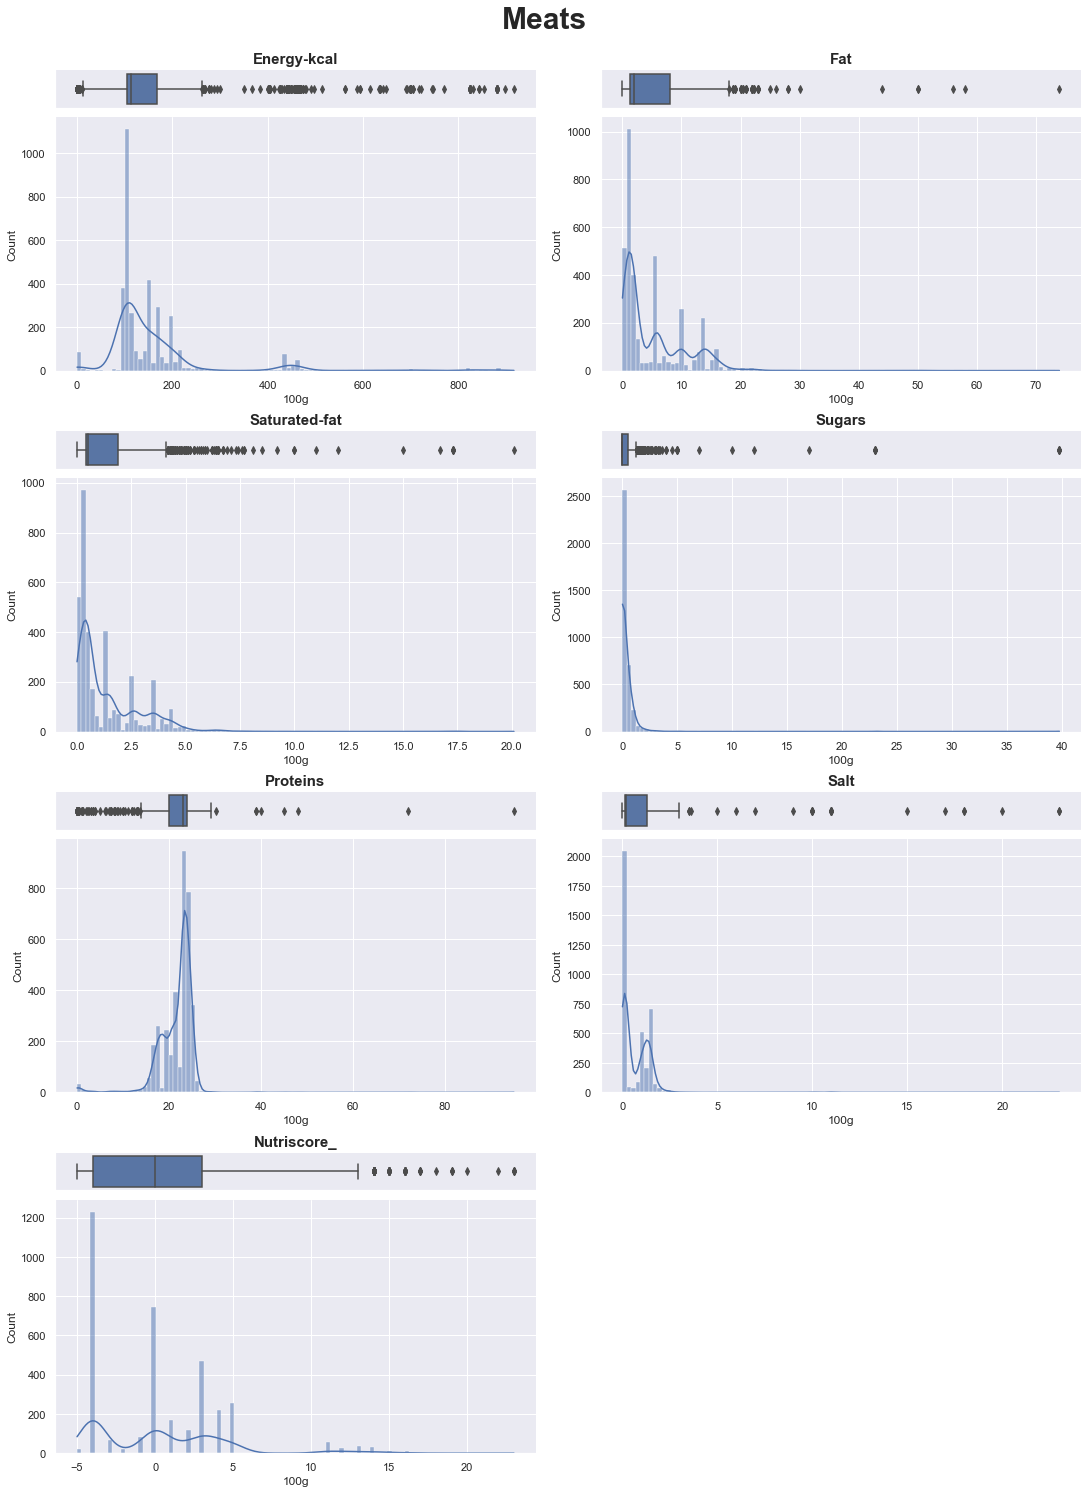

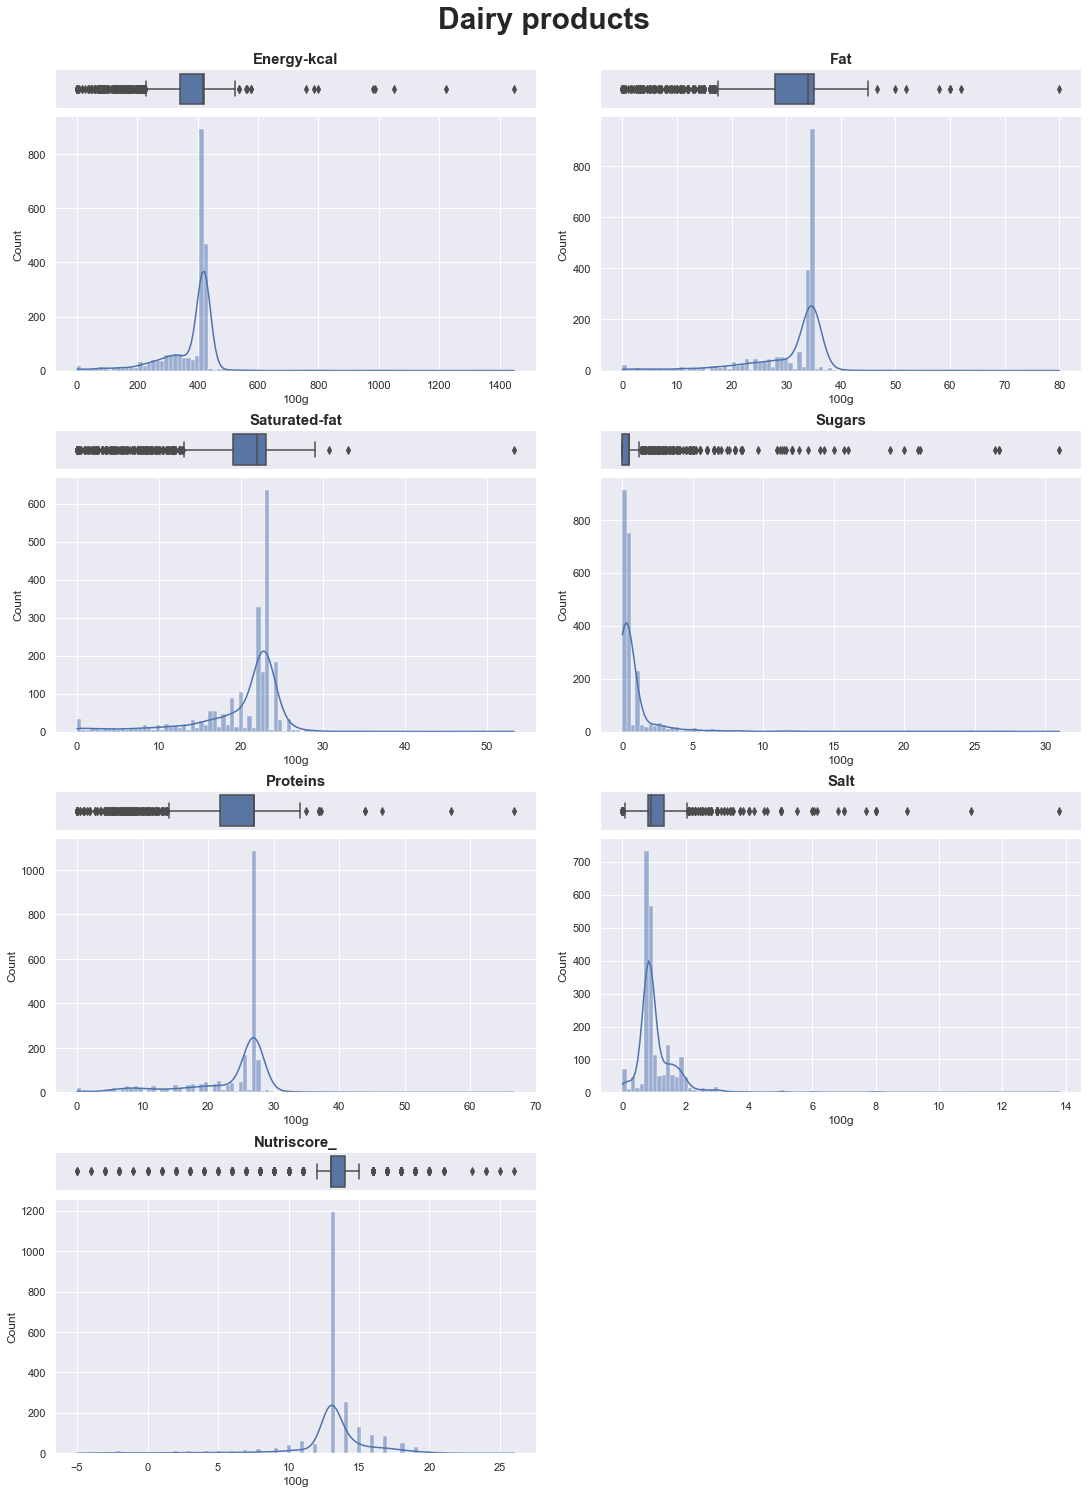

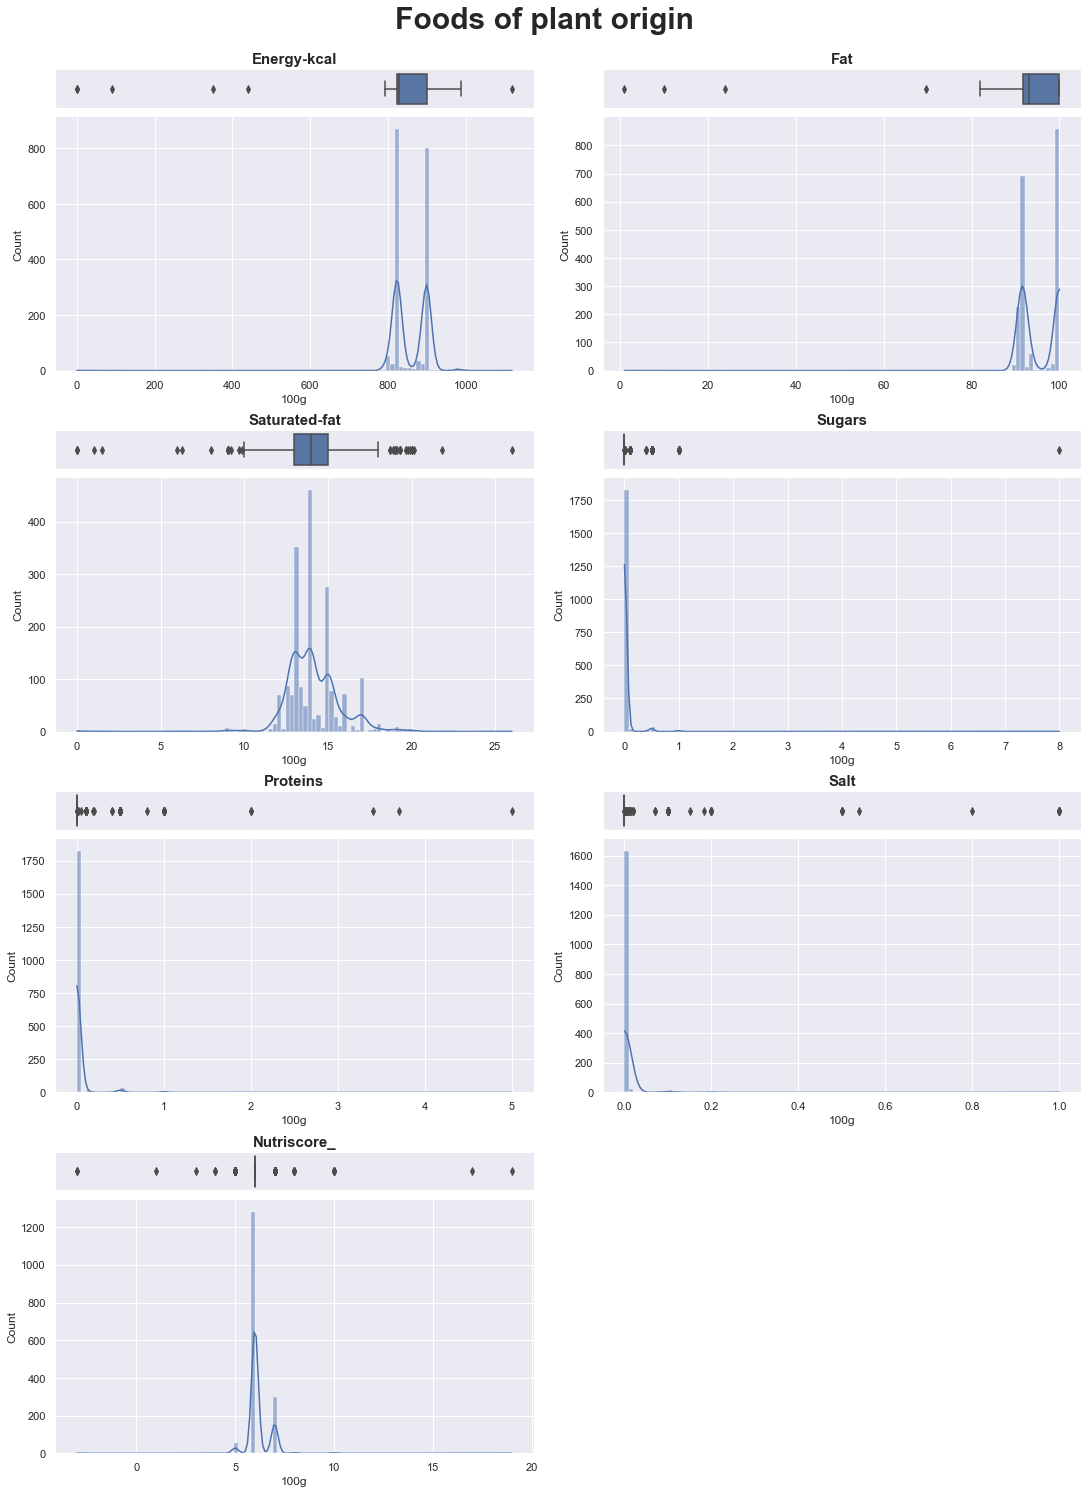

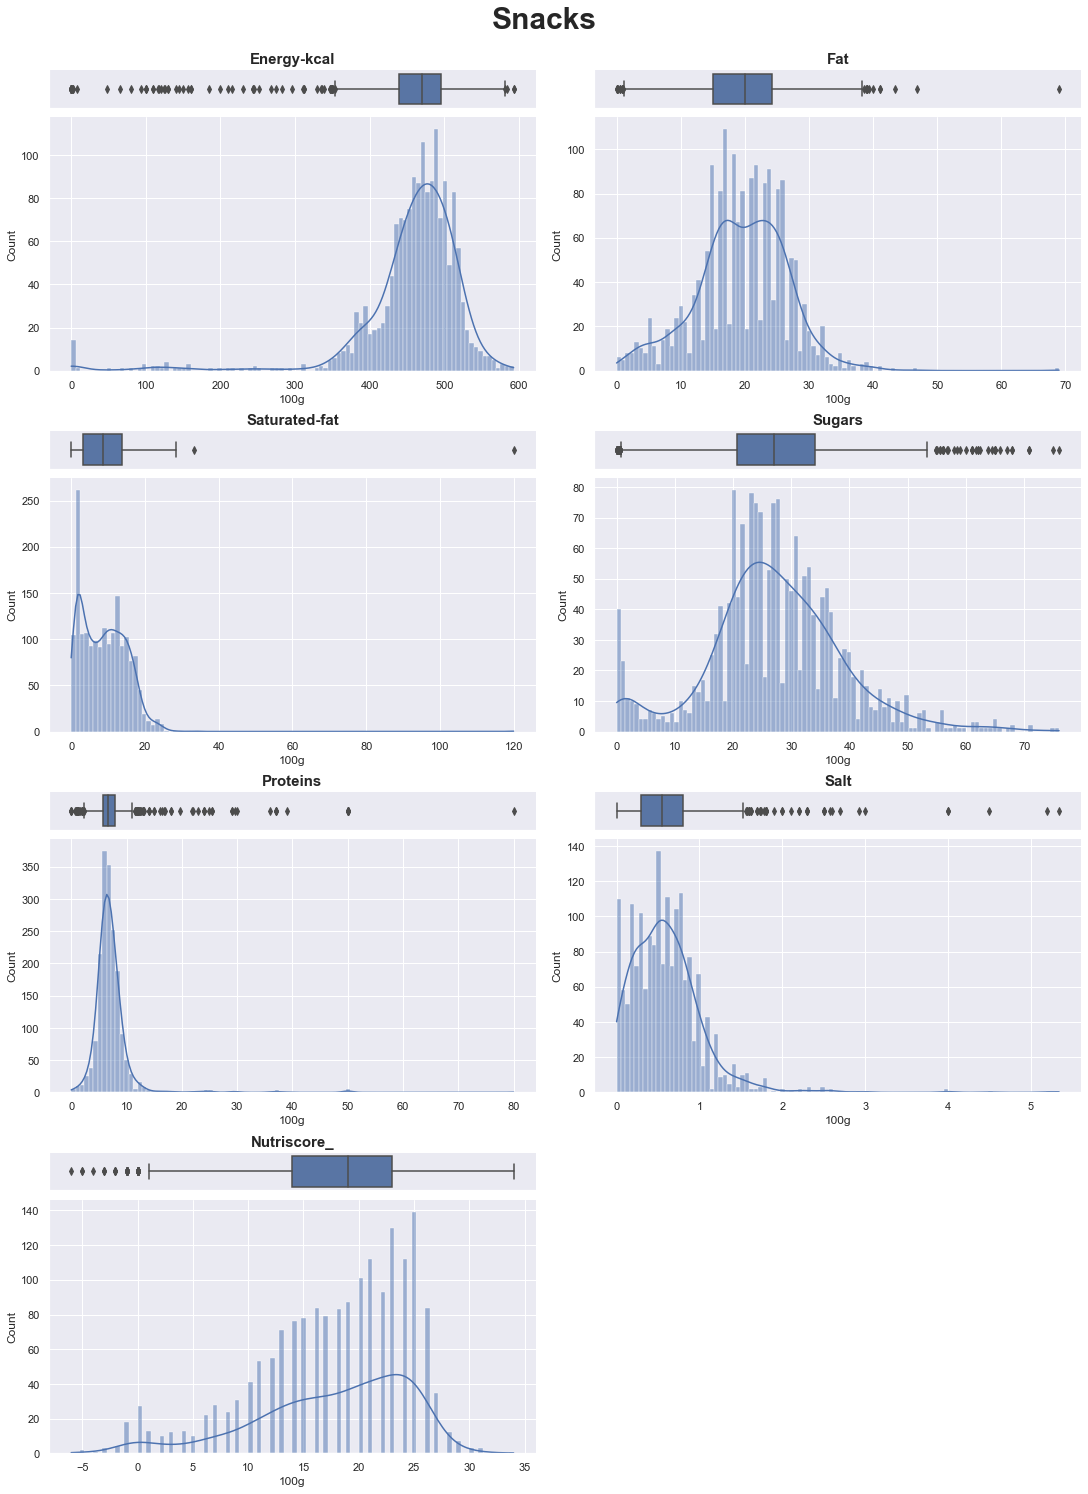

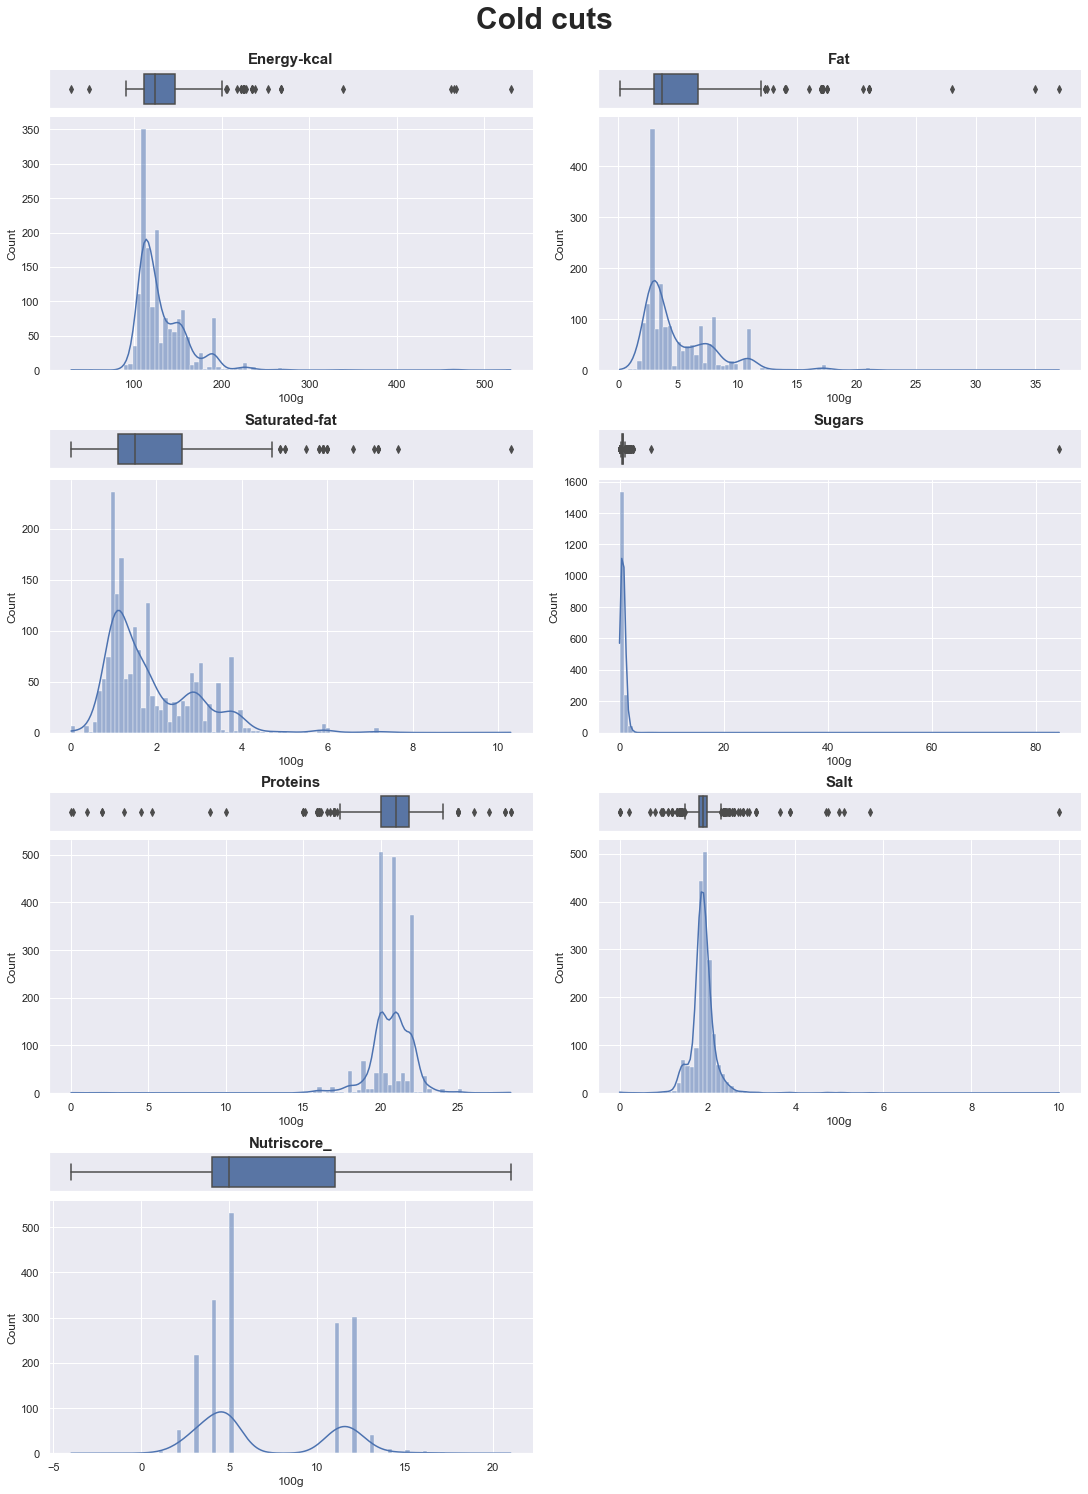

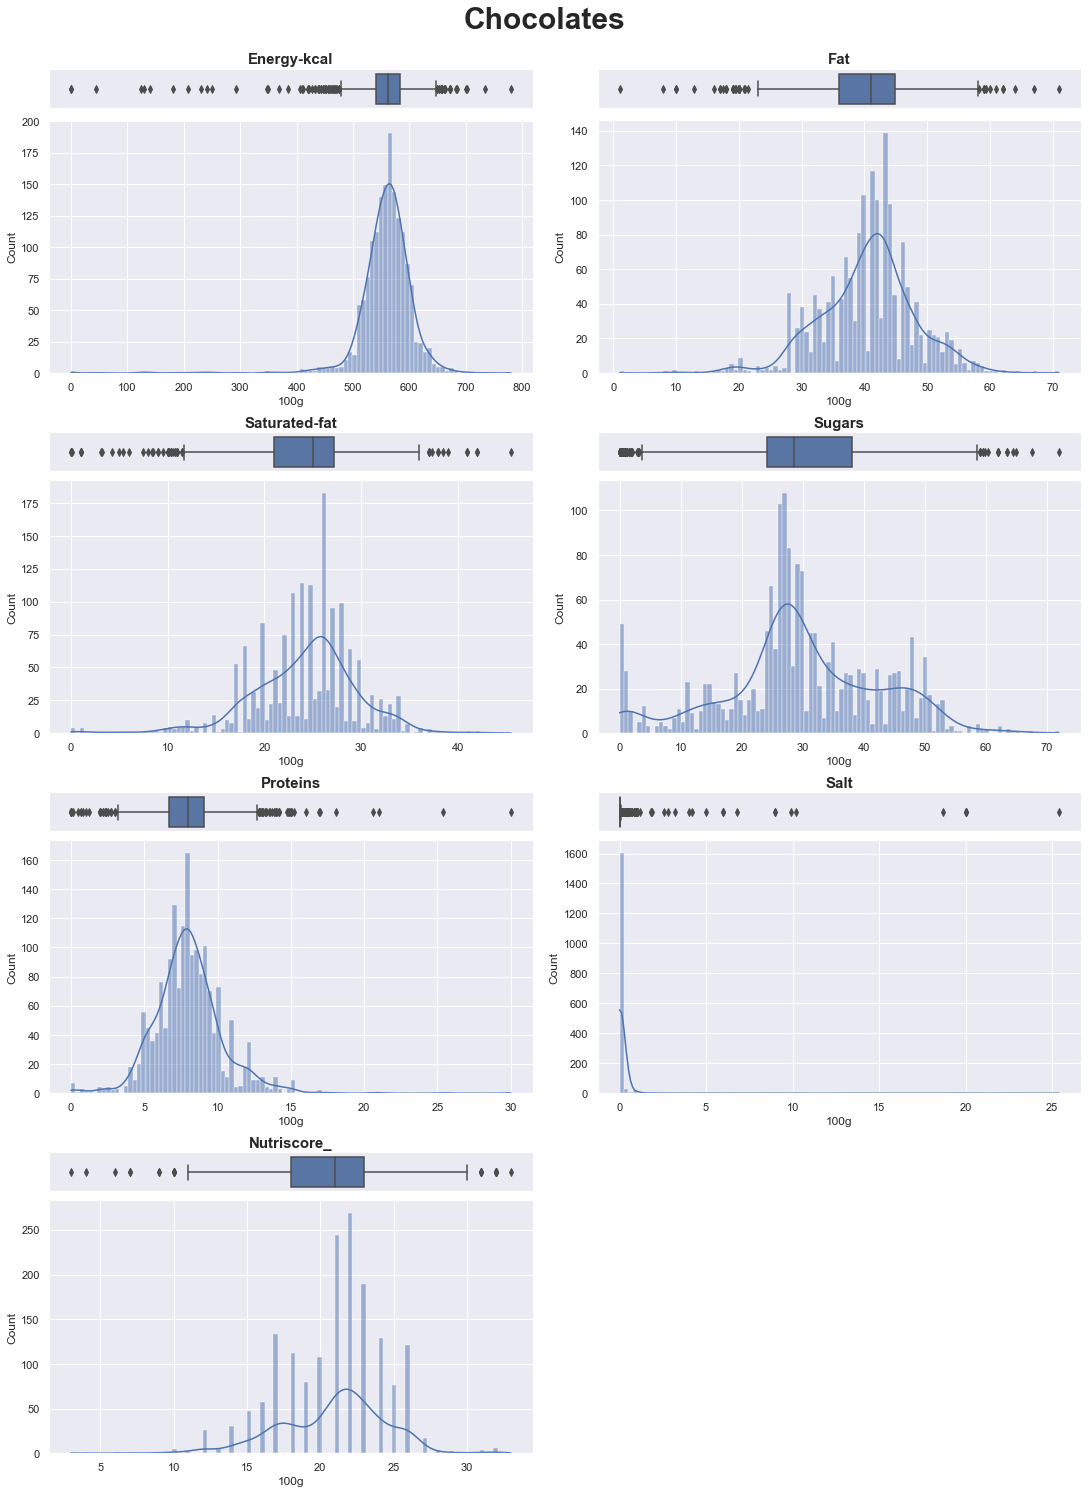

In [152]:
for category in df_with_categories["renamed_category"].unique():
    
    df_temp_by_cat = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    fig = plt.figure(constrained_layout=True, figsize=[15,20])
    fig.suptitle(category, size=30, fontweight="bold", y=1.03)
    spec = fig.add_gridspec(ncols=2, nrows=8, width_ratios=[1,1], height_ratios=[0.3,2,0.3,2,0.3,2,0.3,2])
    
    # to cycle through the columns 
    col_boxplot, col_histplot = 0, 0
    
    for i in range(8):
        
        for j in range(2):
            
            if i % 2 == 0:
                
                if col_boxplot > len(NUMERIC_COLS_APP) - 1:
                    break
                    
                ax_box = fig.add_subplot(spec[i, j])
                boxplot = sns.boxplot(data=df_temp_by_cat, x=NUMERIC_COLS_APP[col_boxplot], ax=ax_box)
                
                # Remove x axis name for the boxplot
                ax_box.set(xlabel="", xticks=[])
                ax_box.set(yticks=[])
                
                boxplot.set_title(NUMERIC_COLS_APP[col_boxplot][0:-5].capitalize(), fontdict={ "fontsize": 15, "fontweight": "bold" })
                
                col_boxplot += 1
                
            elif i % 2 != 0:
                
                if col_histplot > len(NUMERIC_COLS_APP) - 1:
                    break
                
                ax_hist = fig.add_subplot(spec[i, j])
                sns.histplot(data=df_temp_by_cat, x=NUMERIC_COLS_APP[col_histplot], bins=100,  kde=True,  ax=ax_hist)
                ax_hist.set(xlabel="100g")
                
                col_histplot += 1
    
    plt.savefig("img/nan-" + category + ".png", bbox_inches="tight")
    sns.despine(fig)    

In [ ]:
XXXXXXXXXXXXXXX

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.1. Treating Outliers with Percentile</h3>
</div>

<div class="alert alert-block alert-info">
   Most of the distribution are not normal so, due to that we are going to treat the outliers through <b>Percentile</b>
</div>

In [145]:
df_without_outliers_by_percentile = pd.DataFrame()

In [146]:
df_with_categories[df_with_categories["renamed_category"] == "Dairy products"].describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutriscore_score,nova_group
count,2145.000000,2181.000000,2179.000000,2184.000000,2189.000000,2187.000000,2161.000000,558.000000
mean,374.316650,30.512157,19.988377,0.851046,23.372145,1.104489,13.082369,3.191756
std,97.758202,7.894668,5.529278,2.114449,6.900639,0.828836,3.135766,0.394036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,3.000000
25%,342.000000,28.000000,19.000000,0.000000,21.799999,0.800000,13.000000,3.000000
50%,417.000000,34.000000,22.000000,0.500000,27.000000,0.900000,13.000000,3.000000
75%,419.000000,35.000000,23.000000,0.500000,27.000000,1.300000,14.000000,3.000000
max,1448.000000,80.000000,53.299999,31.000000,66.699997,13.800000,26.000000,4.000000


<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>percentiles</b>
</div>

In [147]:
for category in df_with_categories["renamed_category"].unique():
    # for each category, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        # Defining threshold max and min by cateogy and
        min_threshold, max_threshold = df_temp_outliers[col].quantile([0.05, 0.95])
        df_temp_outliers.loc[(df_temp_outliers[col] < min_threshold) | (df_temp_outliers[col] > max_threshold), col] = np.nan
        
    df_without_outliers_by_percentile = pd.concat([df_without_outliers_by_percentile, df_temp_outliers])

In [148]:
df_without_outliers_by_percentile[df_without_outliers_by_percentile["renamed_category"] == "Dairy products"].describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutriscore_score,nova_group
count,1941.000000,2027.000000,1983.000000,2083.000000,2032.000000,1999.000000,1953.000000,558.000000
mean,383.966888,31.441645,20.657993,0.498331,24.055288,1.011969,13.323605,3.191756
std,60.760628,5.484067,3.753227,0.666135,5.292463,0.366409,1.506727,0.394036
min,175.000000,12.000000,7.000000,0.000000,7.500000,0.300000,8.000000,3.000000
25%,357.000000,29.000000,19.000000,0.000000,23.000000,0.800000,13.000000,3.000000
50%,417.000000,34.000000,22.000000,0.500000,27.000000,0.900000,13.000000,3.000000
75%,418.000000,35.000000,23.000000,0.500000,27.000000,1.107500,14.000000,3.000000
max,430.000000,35.000000,24.000000,3.500000,28.000000,2.000000,17.000000,4.000000


In [149]:
df_analysis(df_without_outliers_by_percentile, "df_without_outliers_by_percentile", "code")


Analysis of df_without_outliers_by_percentile dataset
--------------------------------------------------------------------
- Dataset shape:                  16416 rows and 15 columns
- Total of NaN values:            43470
- Percentage of NaN:              17.65 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns   ( memory usage: 5.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,code,object,16416,0,0.00
1,last_modified_datetime,datetime64[ns],16416,0,0.00
3,categories,category,16416,0,0.00
4,main_category,category,16416,0,0.00
5,renamed_category,object,16416,0,0.00
2,product_name,object,16374,42,0.26
6,image_url,object,15740,676,4.12
10,sugars_100g,float32,12204,4212,25.66
9,saturated-fat_100g,float32,12194,4222,25.72
8,fat_100g,float32,12164,4252,25.90


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.2. Treating Outliers with Z Score</h3>
</div>

<div class="alert alert-block alert-info">
    Calculating the <b>Z Score</b> to work on outliers
</div>

In [ ]:
df_without_outliers_by_zscore = pd.DataFrame()

In [ ]:
df_with_categories[df_with_categories["renamed_category"] == "Dairy products"].describe()

<div class="alert alert-block alert-info">
    Deleting <b>outliers</b> with <b>Z Score</b>
</div>

In [ ]:
for category in df_with_categories["renamed_category"].unique():
    # for each category, we are going to define the max and min threshold to replace outliers
    df_temp_outliers = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        
        std = 3
        if col == "nutriscore_score":
            std = 5
            
        # Defining the Z Score
        df_temp_outliers[col + "_zscore"] = (df_temp_outliers[col] - df_temp_outliers[col].mean()) / df_temp_outliers[col].std()
        df_temp_outliers.loc[(df_temp_outliers[col + "_zscore"] > std) | (df_temp_outliers[col + "_zscore"] < -std), col] = np.nan
        del df_temp_outliers[col + "_zscore"]
        
    df_without_outliers_by_zscore = pd.concat([df_without_outliers_by_zscore, df_temp_outliers])

In [ ]:
df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == "Dairy products"].describe()

In [ ]:
df_analysis(df_without_outliers_by_zscore, "df_without_outliers_by_zscore", "code")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">7.3. Comparison of Outliers treatment</h3>
</div>

<div class="alert alert-block alert-info">
    <b>Plotting</b> the comparison between data before and after treating <b>outliers</b> with <b>percentiles</b>
</div>

In [ ]:
for category in df_with_categories["renamed_category"].unique():
    
    df_temp = df_with_categories[df_with_categories["renamed_category"] == category].copy()
    df_temp_by_percentile = df_without_outliers_by_percentile[df_without_outliers_by_percentile["renamed_category"] == category].copy()
    df_temp_by_zscore = df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == category].copy()
    
    for col in NUMERIC_COLS_APP:
        
        # Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
        fig, ((ax_box, ax_box_percentile, ax_box_zscore), (ax_hist, ax_hist_percentile, ax_hist_zscore)) = \
                                                            plt.subplots(nrows=2, ncols=3, figsize=[18,8], sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

        # Title for the complete RR078466118RUfigure
        fig.suptitle((col[0:-5].capitalize() + " in " + category), fontsize="x-large", fontweight="bold")

        # Assigning a graph to each ax
        ax_box.title.set_text("Before treating outliers")
        ax_box_percentile.title.set_text("After percentiles")
        ax_box_zscore.title.set_text("After zscore")
        
        sns.boxplot(data=df_temp, x=col, ax=ax_box)
        sns.boxplot(data=df_temp_by_percentile, x=col, ax=ax_box_percentile)
        sns.boxplot(data=df_temp_by_zscore, x=col, ax=ax_box_zscore)
        
        sns.histplot(data=df_temp, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist)
        sns.histplot(data=df_temp_by_percentile, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist_percentile)
        sns.histplot(data=df_temp_by_zscore, x=col, bins=100, binwidth=3, kde=True, ax=ax_hist_zscore)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel="")
        ax_box.set(yticks=[])
        ax_box_percentile.set(xlabel="")
        ax_box_percentile.set(yticks=[])
        ax_box_zscore.set(xlabel="")
        ax_box_zscore.set(yticks=[])

        plt.tight_layout() 
        sns.despine(fig)

<div class="alert alert-block alert-success">
    After treating <b>the Outliers</b> and analyzing the results, we have selected the dataset treated with <b>Z Score</b>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">8. Treating missing-values</h2>
</div>

<div class="alert alert-block alert-info">
    To select <b>the imputation way of missing-values</b>, we will go through the following steps:
    <ul style="list-style-type: square;">
        <li>Select a subset of data</li>
        <li>Split subset into Training and Testing Sets</li>
        <li>Make imputation through <b>SimpleImputer</b>, <b>CustomImputer</b>, <b>KNN Imputer</b></li>
        <li>Comparación de imputación mediante desviación estándar y RMSE</li>
    </ul>
</div>

<table style="border: 1px solid #FF7200; color: #FF7200;" align="left">
	<tr style="border: 1px solid #FF7200; color: #FF7200;">
		<th style="font-weight: bold;">Field</th>
        <th style="font-weight: bold;">Description</th>
        <th style="font-weight: bold;">Required</th>
		<th style="font-weight: bold;">Open Food Data field</th>
 	</tr>
 	<tr>
		<td align="left">Energetic value</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">energy-kcal_100g</td>
 	</tr>
 	<tr>
		<td align="left">Fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">No</td>
        <td align="left">fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Saturated fat</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">saturated-fat_100g</td>
 	</tr>
 	<tr>
		<td align="left">Sugar</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">sugars_100g</td>
 	</tr>
  	<tr>
		<td align="left">Protein</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">proteins_100g</td>
 	</tr>
  	<tr>
		<td align="left">Salt</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">salt_100g</td>
 	</tr>
  	<tr>
		<td align="left">Nutri-Score</td>
        <td align="center">Nutri-Score</td>
		<td align="center">Yes</td>
        <td align="left">nutriscore_score</td>
 	</tr>
  	<tr>
		<td align="left">Code</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">code</td>
 	</tr>
    <tr>
		<td align="left">Last modified</td>
        <td align="center">App/Basic field</td>
		<td align="center">Yes</td>
        <td align="left">last_modified_datetime</td>
 	</tr>
    <tr>
		<td align="left">Product name</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">product_name</td>
 	</tr>
    <tr>
		<td align="left">Category</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">main_category_en<br>categories<br>renamed_category</td>
 	</tr>
    <tr>
		<td align="left">Image</td>
        <td align="center">App/Basic field</td>
		<td align="center">No</td>
        <td align="left">image_url</td>
 	</tr>
</table>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.1. Select a subset of data</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to work with the category who has more records
</div>

In [ ]:
df_without_outliers_by_zscore.groupby("renamed_category")["code"].count().sort_values(ascending=False)

In [ ]:
df_subset = df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == "Meats"].copy()

In [ ]:
df_subset.shape

<div class="alert alert-block alert-info">
    Now, we are going to select only the rows without missing-values
</div>

In [ ]:
df_subset = pd.DataFrame(df_subset[df_subset[NUMERIC_COLS_APP].notnull().all(axis=1)]).reset_index(drop=True)

<div class="alert alert-block alert-info">
    At this point, we have the subset of data
</div>

In [ ]:
df_subset.shape

<div class="alert alert-block alert-info">
    Randomly Add NaN up to 30% of data for each column in each category present in dataset
</div>

In [ ]:
df_subset_NaN = df_subset[NUMERIC_COLS_APP].mask(np.random.random(df_subset[NUMERIC_COLS_APP].shape) < 0.3)

In [ ]:
df_subset_NaN = df_subset_NaN.join(df_subset[OTHER_COLS_APP])
df_subset_NaN = df_subset_NaN[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [ ]:
df_subset_NaN.head()

<div class="alert alert-block alert-info">
    Slipt the dataset into train and test
</div>

In [ ]:
train, test = train_test_split(df_subset[["renamed_category"] + NUMERIC_COLS_APP], test_size=0.3)

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.2. Imputation on subset by SimpleImputer</h3>
</div>

In [ ]:
train_SimpleImputer = train[NUMERIC_COLS_APP].copy()

In [ ]:
test_SimpleImputer = test[NUMERIC_COLS_APP].copy()

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [ ]:
impute = SimpleImputer(missing_values=np.nan, strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [ ]:
impute.fit(train_SimpleImputer)

In [ ]:
temp_imputed = impute.transform(train_SimpleImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
train_SimpleImputer = pd.DataFrame(temp_imputed, index=train_SimpleImputer.index, columns=train_SimpleImputer.columns)

In [ ]:
train_SimpleImputer = train_SimpleImputer.join(df_subset[OTHER_COLS_APP])

In [ ]:
train_SimpleImputer = train_SimpleImputer[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [ ]:
train_SimpleImputer.head(5)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [ ]:
temp_imputed = impute.transform(test_SimpleImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
test_SimpleImputer = pd.DataFrame(temp_imputed, index=test_SimpleImputer.index, columns=test_SimpleImputer.columns)

In [ ]:
test_SimpleImputer = test_SimpleImputer.join(df_subset[OTHER_COLS_APP])

In [ ]:
test_SimpleImputer = test_SimpleImputer[OTHER_COLS_APP + NUMERIC_COLS_APP]

In [ ]:
test_SimpleImputer.head(5)

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [ ]:
df_subset_SimpleImputer = pd.concat([train_SimpleImputer, test_SimpleImputer])

In [ ]:
df_analysis(df_subset_SimpleImputer, "df_subset_SimpleImputer", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.3. Imputation on subset by Custom Imputer</h3>
</div>

In [ ]:
train_CustomImputer = train.copy()

In [ ]:
test_CustomImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [ ]:
encode(train_CustomImputer["renamed_category"])
encode(test_CustomImputer["renamed_category"])

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler_features = scaler.fit_transform(train_CustomImputer)

In [ ]:
train_CustomImputer = pd.DataFrame(scaler_features, index=train_CustomImputer.index, columns=train_CustomImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [ ]:
impute = GroupImputer(group_cols=["renamed_category"], target=NUMERIC_COLS_APP, strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [ ]:
impute.fit(train_CustomImputer)

In [ ]:
temp_imputed = impute.transform(train_CustomImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
train_CustomImputer = pd.DataFrame(temp_imputed, index=train_CustomImputer.index, columns=train_CustomImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_CustomImputer = pd.DataFrame(scaler.inverse_transform(train_CustomImputer), index=train_CustomImputer.index, columns=train_CustomImputer.columns)

# Rebuilding the dataframe as the original
del train_CustomImputer["renamed_category"]
train_CustomImputer = train_CustomImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_CustomImputer = train_CustomImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
train_CustomImputer.head(5)

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [ ]:
scaler_features = scaler.fit_transform(test_CustomImputer)

In [ ]:
test_CustomImputer = pd.DataFrame(scaler_features, index=test_CustomImputer.index, columns=test_CustomImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [ ]:
temp_imputed = impute.transform(test_CustomImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
test_CustomImputer = pd.DataFrame(temp_imputed, index=test_CustomImputer.index, columns=test_CustomImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_CustomImputer = pd.DataFrame(scaler.inverse_transform(test_CustomImputer), index=test_CustomImputer.index, columns=test_CustomImputer.columns)

# Rebuilding the dataframe as the original
del test_CustomImputer["renamed_category"]
test_CustomImputer = test_CustomImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_CustomImputer = test_CustomImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
test_CustomImputer.head(5)

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [ ]:
df_subset_CustomImputer = pd.concat([train_CustomImputer, test_CustomImputer])

In [ ]:
df_analysis(df_subset_CustomImputer, "df_subset_CustomImputer", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.4. Imputation on subset by KNN Imputer</h3>
</div>

In [ ]:
train_KNNImputer = train.copy()

In [ ]:
test_KNNImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [ ]:
encode(train_KNNImputer["renamed_category"])
encode(test_KNNImputer["renamed_category"])

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [ ]:
scaler_features = scaler.fit_transform(train_KNNImputer)

In [ ]:
train_KNNImputer = pd.DataFrame(scaler_features, index=train_KNNImputer.index, columns=train_KNNImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [ ]:
impute = KNNImputer()

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [ ]:
impute.fit(train_KNNImputer)

In [ ]:
temp_imputed = impute.transform(train_KNNImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
train_KNNImputer = pd.DataFrame(temp_imputed, index=train_KNNImputer.index, columns=train_KNNImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_KNNImputer = pd.DataFrame(scaler.inverse_transform(train_KNNImputer), index=train_KNNImputer.index, columns=train_KNNImputer.columns)

# Rebuilding the dataframe as the original
del train_KNNImputer["renamed_category"]
train_KNNImputer = train_KNNImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_KNNImputer = train_KNNImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
train_KNNImputer.head(5)

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [ ]:
scaler_features = scaler.fit_transform(test_KNNImputer)

In [ ]:
test_KNNImputer = pd.DataFrame(scaler_features, index=test_KNNImputer.index, columns=test_KNNImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [ ]:
temp_imputed = impute.transform(test_KNNImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
test_KNNImputer = pd.DataFrame(temp_imputed, index=test_KNNImputer.index, columns=test_KNNImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_KNNImputer = pd.DataFrame(scaler.inverse_transform(test_KNNImputer), index=test_KNNImputer.index, columns=test_KNNImputer.columns)

# Rebuilding the dataframe as the original
del test_KNNImputer["renamed_category"]
test_KNNImputer = test_KNNImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_KNNImputer = test_KNNImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
test_KNNImputer.head(5)

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [ ]:
df_subset_KNNImputer = pd.concat([train_KNNImputer, test_KNNImputer])

In [ ]:
df_analysis(df_subset_KNNImputer, "df_subset_KNNImputer", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.5. Imputation on subset by Iterative Imputer</h3>
</div>

In [ ]:
train_IterativeImputer = train.copy()

In [ ]:
test_IterativeImputer = test.copy()

<div class="alert alert-block alert-info">
    Encoding the featured "renamed_category" to work on it
</div>

In [ ]:
encode(train_IterativeImputer["renamed_category"])
encode(test_IterativeImputer["renamed_category"])

<div class="alert alert-block alert-info">
    Normalizing the dateset <b>train</b> to work on it
</div>

In [ ]:
scaler_features = scaler.fit_transform(train_IterativeImputer)

In [ ]:
train_IterativeImputer = pd.DataFrame(scaler_features, index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)

<div class="alert alert-block alert-info">
    Initializing the imputer
</div>

In [ ]:
impute = IterativeImputer(estimator=BayesianRidge(), imputation_order="ascending", initial_strategy="mean")

<div class="alert alert-block alert-info">
    Making the imputation <b>(fit/transform)</b> in <b>train set</b>
</div>

In [ ]:
impute.fit(train_IterativeImputer)

In [ ]:
temp_imputed = impute.transform(train_IterativeImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
train_IterativeImputer = pd.DataFrame(temp_imputed, index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
train_IterativeImputer = pd.DataFrame(scaler.inverse_transform(train_IterativeImputer), index=train_IterativeImputer.index, columns=train_IterativeImputer.columns)

# Rebuilding the dataframe as the original
del train_IterativeImputer["renamed_category"]
train_IterativeImputer = train_IterativeImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
train_IterativeImputer = train_IterativeImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
train_IterativeImputer.head(5)

<div class="alert alert-block alert-info">
     Normalizing the dateset <b>test</b> to work on it
</div>

In [ ]:
scaler_features = scaler.fit_transform(test_IterativeImputer)

In [ ]:
test_IterativeImputer = pd.DataFrame(scaler_features, index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)

<div class="alert alert-block alert-info">
     Making the imputation <b>(transform)</b> in <b>test set</b>
</div>

In [ ]:
temp_imputed = impute.transform(test_IterativeImputer)

<div class="alert alert-block alert-info">
    Rebuilding the dataset as original
</div>

In [ ]:
test_IterativeImputer = pd.DataFrame(temp_imputed, index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)
    
# Desnormalizing and formatting data to DataFrame
test_IterativeImputer = pd.DataFrame(scaler.inverse_transform(test_IterativeImputer), index=test_IterativeImputer.index, columns=test_IterativeImputer.columns)

# Rebuilding the dataframe as the original
del test_IterativeImputer["renamed_category"]
test_IterativeImputer = test_IterativeImputer.join(df_subset[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
test_IterativeImputer = test_IterativeImputer[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]

In [ ]:
test_IterativeImputer.head(5)

<div class="alert alert-block alert-info">
    Concatenating the dataset
</div>

In [ ]:
df_subset_IterativeImputer = pd.concat([train_IterativeImputer, test_IterativeImputer])

In [ ]:
df_analysis(df_subset_IterativeImputer, "df_subset_IterativeImputer", "code", flag="complete")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">8.6. Comparison of imputations on subsets</h3>
</div>

<div class="alert alert-block alert-info">
    Concatenating the dataframes to make a comparison
</div>

In [ ]:
df_subset["data"] = "Original"
df_subset_SimpleImputer["data"] = "Simple Imputer"
df_subset_CustomImputer["data"] = "Custom Imputer"
df_subset_KNNImputer["data"] = "KNN Imputer"
df_subset_IterativeImputer["data"] = "Iterative Imputer"

In [ ]:
df_comparision = pd.concat([df_subset, df_subset_SimpleImputer, df_subset_CustomImputer, df_subset_KNNImputer, df_subset_IterativeImputer])

In [ ]:
plt.figure(figsize=[12,10])
sns.boxplot(x=df_comparision["data"], y=df_comparision["energy-kcal_100g"], showmeans=True, 
            meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
plt.title("Comparison of imputations on variable \"energy-kcal_100g\" in category Meats", size=14)
plt.xlabel("Original dataset and datasets imputed", size=12)
plt.show()

<div class="alert alert-block alert-info">
    Calculating Root Mean Square Error for each imputation
</div>

In [ ]:
rmse_dict = {}
for data in df_comparision["data"].unique():
    if data != "Original":
        MSE = mean_squared_error(df_subset["energy-kcal_100g"], (df_comparision.loc[df_comparision["data"] == data, "energy-kcal_100g"]))
        RMSE = math.sqrt(MSE)
        rmse_dict[data] = RMSE
        print("Root Mean Square Error by", data, "is :", RMSE)
        
rmse_df = pd.DataFrame

In [ ]:
rmse_df = pd.DataFrame(rmse_dict.items(), columns=["Method", "RMSE"])
rmse_df

In [ ]:
fig = plt.subplots(figsize=(10, 10))
plot = sns.barplot(x="Method", y="RMSE", data=rmse_df)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Methods", size=12)
plt.title("Root Mean Square Error of mmputations to energy-kcal_100g", size=14)

<div class="alert alert-block alert-success">
    Based on the comparison of results and Root Mean Square Error, the method selected to make imputations will be <b>KNN Imputer</b>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">9. Making imputation with KNN Imputer</h2>
</div>

In [ ]:
df_without_outliers_by_zscore["renamed_category"].unique()

In [ ]:

df_analysis(df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == "Wines"], "df_KNN", "code", flag="complete")

In [ ]:
df_KNN = pd.DataFrame()

for category in df_without_outliers_by_zscore["renamed_category"].unique():

    df_flag = df_without_outliers_by_zscore[df_without_outliers_by_zscore["renamed_category"] == category].copy()
    df_temp = df_flag[["renamed_category"] + NUMERIC_COLS_APP].copy()
    
    # Encoding the featured "renamed_category" to work on it 
    encode(df_temp["renamed_category"])
    
    # Normalizing the dateset train to work on it 
    scaler_features = scaler.fit_transform(df_temp)
    df_temp = pd.DataFrame(scaler_features, index=df_temp.index, columns=df_temp.columns)
    
    # Initializing the imputer 
    impute = KNNImputer()
    
    # Making the imputation
    impute.fit(df_temp)
    temp_imputed = impute.transform(df_temp)
    
    # Rebuilding the dataset as original 
    df_temp = pd.DataFrame(temp_imputed, index=df_temp.index, columns=df_temp.columns)
    
    # Desnormalizing and formatting data to DataFrame
    df_temp = pd.DataFrame(scaler.inverse_transform(df_temp), index=df_temp.index, columns=df_temp.columns)

    # Rebuilding the dataframe as the original
    del df_temp["renamed_category"]
    df_temp = df_temp.join(df_without_outliers_by_zscore[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"]])
    df_temp = df_temp[["code", "last_modified_datetime", "product_name", "main_category", "categories", "renamed_category", "image_url"] + NUMERIC_COLS_APP]
    
    df_KNN = pd.concat([df_KNN, df_temp])    

In [ ]:
df_analysis(df_KNN, "df_KNN", "code", flag="complete")

In [ ]:
df_KNN.to_csv("datasets\dataset_cleaned.csv", index=False)